In [1]:

######## snakemake preamble start (automatically inserted, do not edit) ########
library(methods)
Snakemake <- setClass(
    "Snakemake",
    slots = c(
        input = "list",
        output = "list",
        params = "list",
        wildcards = "list",
        threads = "numeric",
        log = "list",
        resources = "list",
        config = "list",
        rule = "character",
        bench_iteration = "numeric",
        scriptdir = "character",
        source = "function"
    )
)
snakemake <- Snakemake(
    input = list('data/ATAC_predictions_train_20_predict_80/PCA_ATAC_pred_lasso_formatted_standardized.rds', 'data/sample_types.txt', "input_predictions" = 'data/ATAC_predictions_train_20_predict_80/PCA_ATAC_pred_lasso_formatted_standardized.rds', "input_sample_types" = 'data/sample_types.txt'),
    output = list('Classification_output/PCA_Boosting_normalized_trimmed.rds', "boosting_output" = 'Classification_output/PCA_Boosting_normalized_trimmed.rds'),
    params = list(),
    wildcards = list(),
    threads = 5,
    log = list('logs/processed_notebooks/Classification/PCA_Boosting_normalized_trimmed.r.ipynb', "notebook" = 'logs/processed_notebooks/Classification/PCA_Boosting_normalized_trimmed.r.ipynb'),
    resources = list('mem_mb', 'disk_mb', 'tmpdir', 'time', "mem_mb" = 200000, "disk_mb" = 1000, "tmpdir" = '/scratch/57074499', "time" = '12:00:00'),
    config = list(),
    rule = 'PCA_boosting',
    bench_iteration = as.numeric(NA),
    scriptdir = '/faststorage/project/DELFI1/Workspaces/CarmenAndAnika/Classification/PCA_classification',
    source = function(...){
        wd <- getwd()
        setwd(snakemake@scriptdir)
        source(...)
        setwd(wd)
    }
)
setwd('/faststorage/project/DELFI1/Workspaces/CarmenAndAnika');

######## snakemake preamble end #########


In [2]:
library(dplyr)
library(class)
library(tidyverse)
library(pROC)
library(glmnet)

#install.packages('glmnetUtils')
library(glmnetUtils)


library(gbm)
library(caret)
install.packages("e1071")
library(e1071)



Attaching package: ‘dplyr’

The following objects are masked from ‘package:stats’:

    filter, lag

The following objects are masked from ‘package:base’:

    intersect, setdiff, setequal, union

Registered S3 methods overwritten by 'ggplot2':
  method         from 
  [.quosures     rlang
  c.quosures     rlang
  print.quosures rlang
Registered S3 method overwritten by 'rvest':
  method            from
  read_xml.response xml2
── Attaching packages ─────────────────────────────────────── tidyverse 1.2.1 ──
✔ ggplot2 3.1.1     ✔ readr   1.3.1
✔ tibble  3.1.4     ✔ purrr   0.3.4
✔ tidyr   1.1.3     ✔ stringr 1.4.0
✔ ggplot2 3.1.1     ✔ forcats 0.4.0
── Conflicts ────────────────────────────────────────── tidyverse_conflicts() ──
✖ dplyr::filter() masks stats::filter()
✖ dplyr::lag()    masks stats::lag()
Type 'citation("pROC")' for a citation.

Attaching package: ‘pROC’

The following objects are masked from ‘package:stats’:

    cov, smooth, var

Loading required package: Matrix

Atta

In [3]:
#lasso_pred <- readRDS("../../data/ATAC_predictions_train_XX_predict_XX/ATAC_pred_lasso_normalized_trimmed_formatted_standardized.rds")
pred <- readRDS(snakemake@input[["input_predictions"]])

In [4]:
sample_types <- read.table(snakemake@input[["input_sample_types"]], header = F, sep = " ")
#sample_types <- read.table("../../data/sample_types.txt", header = F, sep = " ")

colnames(sample_types) <- c("sample", "sample_type")
head(sample_types)

sample,sample_type
PGDX10344P1,Gastric_cancer
PGDX10346P1,Gastric_cancer
PGDX10349P1,Gastric_cancer
PGDX10351P1,Gastric_cancer
PGDX10566P,Ovarian_Cancer
PGDX10567P,Ovarian_Cancer


In [5]:
data <- merge(pred, sample_types, by="sample")
data <- data %>% mutate(sample_type01 = ifelse(sample_type == "Healthy", 0, 1))
head(data)

sample,PC1,PC2,PC3,PC4,PC5,PC6,PC7,PC8,PC9,...,PC43,PC44,PC45,PC46,PC47,PC48,PC49,PC50,sample_type,sample_type01
PGDX10344P1,-4.342131,1.953977,-13.968322,2.318305,1.685676,-3.381066,6.0445212,-1.1347791,1.74198197,...,0.6274859,-2.622078,1.6339641,0.2876357,2.4162404,1.8695959,0.08770358,-1.2166196,Gastric_cancer,1
PGDX10346P1,-6.078536,-12.661175,-11.678871,-1.872324,1.336255,-1.996692,-6.4118319,7.9706470,12.11108040,...,-2.9572109,-2.308502,0.7707140,-3.6516509,-3.0050707,-1.9374279,-0.15064911,-3.4388000,Gastric_cancer,1
PGDX10349P1,48.179628,-48.671877,57.672198,10.976267,-20.122190,-4.259207,3.0733782,0.6075922,1.57203960,...,0.6475888,2.037660,-1.7877125,2.0789376,-1.0851786,-0.2287387,0.90575811,-0.9010285,Gastric_cancer,1
PGDX10351P1,-35.928939,-11.350262,-13.701368,-14.147165,-4.240782,-5.227815,-0.1563398,5.1853643,-1.26376760,...,2.4307994,5.922993,2.1776501,-2.6065181,1.8807665,2.5498882,-3.57969961,1.5642893,Gastric_cancer,1
PGDX10566P,-3.645149,-8.417624,-18.188105,-4.633597,1.470311,-1.048202,3.6578793,-1.3577985,-0.59132535,...,2.1880247,-4.290371,0.5627505,2.3363121,-0.2994595,2.8081674,2.42526637,1.0627620,Ovarian_Cancer,1
PGDX10567P,9.167948,-9.013273,9.812515,4.895645,-4.504976,4.545019,1.3597509,-2.8620042,0.01220041,...,-1.0443199,3.607826,-2.0018629,3.3426278,-1.0511282,0.7924274,0.98886233,6.8472585,Ovarian_Cancer,1


In [6]:
data <- data %>% select(-sample_type)

In [7]:
data <- data %>% select(-sample)
head(data)

PC1,PC2,PC3,PC4,PC5,PC6,PC7,PC8,PC9,PC10,...,PC42,PC43,PC44,PC45,PC46,PC47,PC48,PC49,PC50,sample_type01
-4.342131,1.953977,-13.968322,2.318305,1.685676,-3.381066,6.0445212,-1.1347791,1.74198197,-0.74881708,...,-2.8077276,0.6274859,-2.622078,1.6339641,0.2876357,2.4162404,1.8695959,0.08770358,-1.2166196,1
-6.078536,-12.661175,-11.678871,-1.872324,1.336255,-1.996692,-6.4118319,7.9706470,12.11108040,5.72266372,...,-1.3210358,-2.9572109,-2.308502,0.7707140,-3.6516509,-3.0050707,-1.9374279,-0.15064911,-3.4388000,1
48.179628,-48.671877,57.672198,10.976267,-20.122190,-4.259207,3.0733782,0.6075922,1.57203960,-2.84910093,...,0.7400773,0.6475888,2.037660,-1.7877125,2.0789376,-1.0851786,-0.2287387,0.90575811,-0.9010285,1
-35.928939,-11.350262,-13.701368,-14.147165,-4.240782,-5.227815,-0.1563398,5.1853643,-1.26376760,0.05546772,...,3.8996607,2.4307994,5.922993,2.1776501,-2.6065181,1.8807665,2.5498882,-3.57969961,1.5642893,1
-3.645149,-8.417624,-18.188105,-4.633597,1.470311,-1.048202,3.6578793,-1.3577985,-0.59132535,-2.49310460,...,1.2274091,2.1880247,-4.290371,0.5627505,2.3363121,-0.2994595,2.8081674,2.42526637,1.0627620,1
9.167948,-9.013273,9.812515,4.895645,-4.504976,4.545019,1.3597509,-2.8620042,0.01220041,0.19581699,...,2.7123738,-1.0443199,3.607826,-2.0018629,3.3426278,-1.0511282,0.7924274,0.98886233,6.8472585,1


In [8]:
data$sample_type01 <- as.factor(data$sample_type01)

In [9]:
cross_validation <- function(dataset, k_inner_cv, k_outer_cv){
    
    observed  <- dataset$sample_type01
    return_tibble <- tibble(observed = observed)
    
    for (i in 1:k_outer_cv){ # repeated Cross-validation loop
    
    set.seed(i)
    cvfolds <- cut(seq_len(nrow(dataset)), breaks = k_inner_cv, labels = F)
    cvfolds <- sample(cvfolds)

    predicted <- rep(NA, nrow(dataset))
    
    for (n in 1:k_inner_cv){
        rows      <- which(cvfolds==n)
        testdata  <- dataset[rows,]
        testlabels <- testdata$sample_type01
        testdata <- testdata %>% select(-sample_type01)
        
        traindata <- dataset[-rows,]
        trainlabels <- traindata$sample_type01
        traindata <- traindata %>% select(-sample_type01)
     
        ################# Nested cross validation #######################
        set.seed(0)
        seeds <- vector(mode = "list", length = 11)
        for(i in 1:10) seeds[[i]]<- sample.int(n=1000, 18)
        #for the last model
        seeds[[11]]<-sample.int(1000, 1)

        trControl_gbm <- trainControl(method = "repeatedcv", 
                                  seeds = seeds,
                                  number = 10, 
                                  repeats = 1,
                                  verboseIter = ifelse(is.null(getOption('knitr.in.progress')), TRUE, FALSE))

        gbmGrid <- expand.grid(interaction.depth = c(1, 2, 3, 4, 5, 6),
                               n.trees = seq(300, 600, 50),
                               shrinkage = c(0.1, 0.2, 0.01),
                               n.minobsinnode = c(10))

        fit1 <- train(x = traindata, 
                     y = trainlabels, 
                     method = "gbm",
                     tuneGrid = gbmGrid,
                     trControl = trControl_gbm, 
                     verbose=F)
        ggplot(fit1)
        message("besttune ntrees")
        message(fit1$bestTune$n.trees)
        message("besttune interaction.depth")
        message(fit1$bestTune$interaction.depth)
        message("besttune shrinkage")
        message(fit1$bestTune$shrinkage)
        message("besttune n.minobsinnode")
        message(fit1$bestTune$n.minobsinnode)
        #################################################################
      
        fitControl <- trainControl()
        fit2 <- train(x = traindata, 
                     y = trainlabels,
                     method = "gbm",
                     trControl = fitControl,
                     verbose = FALSE,
                     tuneGrid = data.frame(n.trees = fit1$bestTune$n.trees,
                                           interaction.depth = fit1$bestTune$interaction.depth,
                                           shrinkage = fit1$bestTune$shrinkage,
                                           n.minobsinnode = fit1$bestTune$n.minobsinnode))
              
    
        tmp <- predict(fit2, newdata = testdata, type = "prob")[,2]
        predicted[rows] <- tmp 
        
    }

    current_round_tibble <- tibble(predicted = predicted)
    return_tibble <- cbind(return_tibble, current_round_tibble)
    } # end of outer cv loop
    
    return(return_tibble)
}

In [10]:
results = cross_validation(data, k_inner_cv = 10, k_outer_cv = 10)

+ Fold01.Rep1: shrinkage=0.01, interaction.depth=1, n.minobsinnode=10, n.trees=600 
- Fold01.Rep1: shrinkage=0.01, interaction.depth=1, n.minobsinnode=10, n.trees=600 
+ Fold01.Rep1: shrinkage=0.01, interaction.depth=2, n.minobsinnode=10, n.trees=600 
- Fold01.Rep1: shrinkage=0.01, interaction.depth=2, n.minobsinnode=10, n.trees=600 
+ Fold01.Rep1: shrinkage=0.01, interaction.depth=3, n.minobsinnode=10, n.trees=600 
- Fold01.Rep1: shrinkage=0.01, interaction.depth=3, n.minobsinnode=10, n.trees=600 
+ Fold01.Rep1: shrinkage=0.01, interaction.depth=4, n.minobsinnode=10, n.trees=600 
- Fold01.Rep1: shrinkage=0.01, interaction.depth=4, n.minobsinnode=10, n.trees=600 
+ Fold01.Rep1: shrinkage=0.01, interaction.depth=5, n.minobsinnode=10, n.trees=600 
- Fold01.Rep1: shrinkage=0.01, interaction.depth=5, n.minobsinnode=10, n.trees=600 
+ Fold01.Rep1: shrinkage=0.01, interaction.depth=6, n.minobsinnode=10, n.trees=600 
- Fold01.Rep1: shrinkage=0.01, interaction.depth=6, n.minobsinnode=10, n.tre

besttune ntrees
600
besttune interaction.depth
5
besttune shrinkage
0.1
besttune n.minobsinnode
10


+ Fold01.Rep1: shrinkage=0.01, interaction.depth=1, n.minobsinnode=10, n.trees=600 
- Fold01.Rep1: shrinkage=0.01, interaction.depth=1, n.minobsinnode=10, n.trees=600 
+ Fold01.Rep1: shrinkage=0.01, interaction.depth=2, n.minobsinnode=10, n.trees=600 
- Fold01.Rep1: shrinkage=0.01, interaction.depth=2, n.minobsinnode=10, n.trees=600 
+ Fold01.Rep1: shrinkage=0.01, interaction.depth=3, n.minobsinnode=10, n.trees=600 
- Fold01.Rep1: shrinkage=0.01, interaction.depth=3, n.minobsinnode=10, n.trees=600 
+ Fold01.Rep1: shrinkage=0.01, interaction.depth=4, n.minobsinnode=10, n.trees=600 
- Fold01.Rep1: shrinkage=0.01, interaction.depth=4, n.minobsinnode=10, n.trees=600 
+ Fold01.Rep1: shrinkage=0.01, interaction.depth=5, n.minobsinnode=10, n.trees=600 
- Fold01.Rep1: shrinkage=0.01, interaction.depth=5, n.minobsinnode=10, n.trees=600 
+ Fold01.Rep1: shrinkage=0.01, interaction.depth=6, n.minobsinnode=10, n.trees=600 
- Fold01.Rep1: shrinkage=0.01, interaction.depth=6, n.minobsinnode=10, n.tre

besttune ntrees
600
besttune interaction.depth
5
besttune shrinkage
0.01
besttune n.minobsinnode
10


+ Fold01.Rep1: shrinkage=0.01, interaction.depth=1, n.minobsinnode=10, n.trees=600 
- Fold01.Rep1: shrinkage=0.01, interaction.depth=1, n.minobsinnode=10, n.trees=600 
+ Fold01.Rep1: shrinkage=0.01, interaction.depth=2, n.minobsinnode=10, n.trees=600 
- Fold01.Rep1: shrinkage=0.01, interaction.depth=2, n.minobsinnode=10, n.trees=600 
+ Fold01.Rep1: shrinkage=0.01, interaction.depth=3, n.minobsinnode=10, n.trees=600 
- Fold01.Rep1: shrinkage=0.01, interaction.depth=3, n.minobsinnode=10, n.trees=600 
+ Fold01.Rep1: shrinkage=0.01, interaction.depth=4, n.minobsinnode=10, n.trees=600 
- Fold01.Rep1: shrinkage=0.01, interaction.depth=4, n.minobsinnode=10, n.trees=600 
+ Fold01.Rep1: shrinkage=0.01, interaction.depth=5, n.minobsinnode=10, n.trees=600 
- Fold01.Rep1: shrinkage=0.01, interaction.depth=5, n.minobsinnode=10, n.trees=600 
+ Fold01.Rep1: shrinkage=0.01, interaction.depth=6, n.minobsinnode=10, n.trees=600 
- Fold01.Rep1: shrinkage=0.01, interaction.depth=6, n.minobsinnode=10, n.tre

besttune ntrees
450
besttune interaction.depth
6
besttune shrinkage
0.1
besttune n.minobsinnode
10


+ Fold01.Rep1: shrinkage=0.01, interaction.depth=1, n.minobsinnode=10, n.trees=600 
- Fold01.Rep1: shrinkage=0.01, interaction.depth=1, n.minobsinnode=10, n.trees=600 
+ Fold01.Rep1: shrinkage=0.01, interaction.depth=2, n.minobsinnode=10, n.trees=600 
- Fold01.Rep1: shrinkage=0.01, interaction.depth=2, n.minobsinnode=10, n.trees=600 
+ Fold01.Rep1: shrinkage=0.01, interaction.depth=3, n.minobsinnode=10, n.trees=600 
- Fold01.Rep1: shrinkage=0.01, interaction.depth=3, n.minobsinnode=10, n.trees=600 
+ Fold01.Rep1: shrinkage=0.01, interaction.depth=4, n.minobsinnode=10, n.trees=600 
- Fold01.Rep1: shrinkage=0.01, interaction.depth=4, n.minobsinnode=10, n.trees=600 
+ Fold01.Rep1: shrinkage=0.01, interaction.depth=5, n.minobsinnode=10, n.trees=600 
- Fold01.Rep1: shrinkage=0.01, interaction.depth=5, n.minobsinnode=10, n.trees=600 
+ Fold01.Rep1: shrinkage=0.01, interaction.depth=6, n.minobsinnode=10, n.trees=600 
- Fold01.Rep1: shrinkage=0.01, interaction.depth=6, n.minobsinnode=10, n.tre

besttune ntrees
600
besttune interaction.depth
4
besttune shrinkage
0.2
besttune n.minobsinnode
10


+ Fold01.Rep1: shrinkage=0.01, interaction.depth=1, n.minobsinnode=10, n.trees=600 
- Fold01.Rep1: shrinkage=0.01, interaction.depth=1, n.minobsinnode=10, n.trees=600 
+ Fold01.Rep1: shrinkage=0.01, interaction.depth=2, n.minobsinnode=10, n.trees=600 
- Fold01.Rep1: shrinkage=0.01, interaction.depth=2, n.minobsinnode=10, n.trees=600 
+ Fold01.Rep1: shrinkage=0.01, interaction.depth=3, n.minobsinnode=10, n.trees=600 
- Fold01.Rep1: shrinkage=0.01, interaction.depth=3, n.minobsinnode=10, n.trees=600 
+ Fold01.Rep1: shrinkage=0.01, interaction.depth=4, n.minobsinnode=10, n.trees=600 
- Fold01.Rep1: shrinkage=0.01, interaction.depth=4, n.minobsinnode=10, n.trees=600 
+ Fold01.Rep1: shrinkage=0.01, interaction.depth=5, n.minobsinnode=10, n.trees=600 
- Fold01.Rep1: shrinkage=0.01, interaction.depth=5, n.minobsinnode=10, n.trees=600 
+ Fold01.Rep1: shrinkage=0.01, interaction.depth=6, n.minobsinnode=10, n.trees=600 
- Fold01.Rep1: shrinkage=0.01, interaction.depth=6, n.minobsinnode=10, n.tre

besttune ntrees
350
besttune interaction.depth
4
besttune shrinkage
0.1
besttune n.minobsinnode
10


+ Fold01.Rep1: shrinkage=0.01, interaction.depth=1, n.minobsinnode=10, n.trees=600 
- Fold01.Rep1: shrinkage=0.01, interaction.depth=1, n.minobsinnode=10, n.trees=600 
+ Fold01.Rep1: shrinkage=0.01, interaction.depth=2, n.minobsinnode=10, n.trees=600 
- Fold01.Rep1: shrinkage=0.01, interaction.depth=2, n.minobsinnode=10, n.trees=600 
+ Fold01.Rep1: shrinkage=0.01, interaction.depth=3, n.minobsinnode=10, n.trees=600 
- Fold01.Rep1: shrinkage=0.01, interaction.depth=3, n.minobsinnode=10, n.trees=600 
+ Fold01.Rep1: shrinkage=0.01, interaction.depth=4, n.minobsinnode=10, n.trees=600 
- Fold01.Rep1: shrinkage=0.01, interaction.depth=4, n.minobsinnode=10, n.trees=600 
+ Fold01.Rep1: shrinkage=0.01, interaction.depth=5, n.minobsinnode=10, n.trees=600 
- Fold01.Rep1: shrinkage=0.01, interaction.depth=5, n.minobsinnode=10, n.trees=600 
+ Fold01.Rep1: shrinkage=0.01, interaction.depth=6, n.minobsinnode=10, n.trees=600 
- Fold01.Rep1: shrinkage=0.01, interaction.depth=6, n.minobsinnode=10, n.tre

besttune ntrees
500
besttune interaction.depth
5
besttune shrinkage
0.2
besttune n.minobsinnode
10


+ Fold01.Rep1: shrinkage=0.01, interaction.depth=1, n.minobsinnode=10, n.trees=600 
- Fold01.Rep1: shrinkage=0.01, interaction.depth=1, n.minobsinnode=10, n.trees=600 
+ Fold01.Rep1: shrinkage=0.01, interaction.depth=2, n.minobsinnode=10, n.trees=600 
- Fold01.Rep1: shrinkage=0.01, interaction.depth=2, n.minobsinnode=10, n.trees=600 
+ Fold01.Rep1: shrinkage=0.01, interaction.depth=3, n.minobsinnode=10, n.trees=600 
- Fold01.Rep1: shrinkage=0.01, interaction.depth=3, n.minobsinnode=10, n.trees=600 
+ Fold01.Rep1: shrinkage=0.01, interaction.depth=4, n.minobsinnode=10, n.trees=600 
- Fold01.Rep1: shrinkage=0.01, interaction.depth=4, n.minobsinnode=10, n.trees=600 
+ Fold01.Rep1: shrinkage=0.01, interaction.depth=5, n.minobsinnode=10, n.trees=600 
- Fold01.Rep1: shrinkage=0.01, interaction.depth=5, n.minobsinnode=10, n.trees=600 
+ Fold01.Rep1: shrinkage=0.01, interaction.depth=6, n.minobsinnode=10, n.trees=600 
- Fold01.Rep1: shrinkage=0.01, interaction.depth=6, n.minobsinnode=10, n.tre

besttune ntrees
500
besttune interaction.depth
5
besttune shrinkage
0.01
besttune n.minobsinnode
10


+ Fold01.Rep1: shrinkage=0.01, interaction.depth=1, n.minobsinnode=10, n.trees=600 
- Fold01.Rep1: shrinkage=0.01, interaction.depth=1, n.minobsinnode=10, n.trees=600 
+ Fold01.Rep1: shrinkage=0.01, interaction.depth=2, n.minobsinnode=10, n.trees=600 
- Fold01.Rep1: shrinkage=0.01, interaction.depth=2, n.minobsinnode=10, n.trees=600 
+ Fold01.Rep1: shrinkage=0.01, interaction.depth=3, n.minobsinnode=10, n.trees=600 
- Fold01.Rep1: shrinkage=0.01, interaction.depth=3, n.minobsinnode=10, n.trees=600 
+ Fold01.Rep1: shrinkage=0.01, interaction.depth=4, n.minobsinnode=10, n.trees=600 
- Fold01.Rep1: shrinkage=0.01, interaction.depth=4, n.minobsinnode=10, n.trees=600 
+ Fold01.Rep1: shrinkage=0.01, interaction.depth=5, n.minobsinnode=10, n.trees=600 
- Fold01.Rep1: shrinkage=0.01, interaction.depth=5, n.minobsinnode=10, n.trees=600 
+ Fold01.Rep1: shrinkage=0.01, interaction.depth=6, n.minobsinnode=10, n.trees=600 
- Fold01.Rep1: shrinkage=0.01, interaction.depth=6, n.minobsinnode=10, n.tre

besttune ntrees
300
besttune interaction.depth
6
besttune shrinkage
0.2
besttune n.minobsinnode
10


+ Fold01.Rep1: shrinkage=0.01, interaction.depth=1, n.minobsinnode=10, n.trees=600 
- Fold01.Rep1: shrinkage=0.01, interaction.depth=1, n.minobsinnode=10, n.trees=600 
+ Fold01.Rep1: shrinkage=0.01, interaction.depth=2, n.minobsinnode=10, n.trees=600 
- Fold01.Rep1: shrinkage=0.01, interaction.depth=2, n.minobsinnode=10, n.trees=600 
+ Fold01.Rep1: shrinkage=0.01, interaction.depth=3, n.minobsinnode=10, n.trees=600 
- Fold01.Rep1: shrinkage=0.01, interaction.depth=3, n.minobsinnode=10, n.trees=600 
+ Fold01.Rep1: shrinkage=0.01, interaction.depth=4, n.minobsinnode=10, n.trees=600 
- Fold01.Rep1: shrinkage=0.01, interaction.depth=4, n.minobsinnode=10, n.trees=600 
+ Fold01.Rep1: shrinkage=0.01, interaction.depth=5, n.minobsinnode=10, n.trees=600 
- Fold01.Rep1: shrinkage=0.01, interaction.depth=5, n.minobsinnode=10, n.trees=600 
+ Fold01.Rep1: shrinkage=0.01, interaction.depth=6, n.minobsinnode=10, n.trees=600 
- Fold01.Rep1: shrinkage=0.01, interaction.depth=6, n.minobsinnode=10, n.tre

besttune ntrees
600
besttune interaction.depth
5
besttune shrinkage
0.1
besttune n.minobsinnode
10


+ Fold01.Rep1: shrinkage=0.01, interaction.depth=1, n.minobsinnode=10, n.trees=600 
- Fold01.Rep1: shrinkage=0.01, interaction.depth=1, n.minobsinnode=10, n.trees=600 
+ Fold01.Rep1: shrinkage=0.01, interaction.depth=2, n.minobsinnode=10, n.trees=600 
- Fold01.Rep1: shrinkage=0.01, interaction.depth=2, n.minobsinnode=10, n.trees=600 
+ Fold01.Rep1: shrinkage=0.01, interaction.depth=3, n.minobsinnode=10, n.trees=600 
- Fold01.Rep1: shrinkage=0.01, interaction.depth=3, n.minobsinnode=10, n.trees=600 
+ Fold01.Rep1: shrinkage=0.01, interaction.depth=4, n.minobsinnode=10, n.trees=600 
- Fold01.Rep1: shrinkage=0.01, interaction.depth=4, n.minobsinnode=10, n.trees=600 
+ Fold01.Rep1: shrinkage=0.01, interaction.depth=5, n.minobsinnode=10, n.trees=600 
- Fold01.Rep1: shrinkage=0.01, interaction.depth=5, n.minobsinnode=10, n.trees=600 
+ Fold01.Rep1: shrinkage=0.01, interaction.depth=6, n.minobsinnode=10, n.trees=600 
- Fold01.Rep1: shrinkage=0.01, interaction.depth=6, n.minobsinnode=10, n.tre

besttune ntrees
600
besttune interaction.depth
5
besttune shrinkage
0.2
besttune n.minobsinnode
10


+ Fold01.Rep1: shrinkage=0.01, interaction.depth=1, n.minobsinnode=10, n.trees=600 
- Fold01.Rep1: shrinkage=0.01, interaction.depth=1, n.minobsinnode=10, n.trees=600 
+ Fold01.Rep1: shrinkage=0.01, interaction.depth=2, n.minobsinnode=10, n.trees=600 
- Fold01.Rep1: shrinkage=0.01, interaction.depth=2, n.minobsinnode=10, n.trees=600 
+ Fold01.Rep1: shrinkage=0.01, interaction.depth=3, n.minobsinnode=10, n.trees=600 
- Fold01.Rep1: shrinkage=0.01, interaction.depth=3, n.minobsinnode=10, n.trees=600 
+ Fold01.Rep1: shrinkage=0.01, interaction.depth=4, n.minobsinnode=10, n.trees=600 
- Fold01.Rep1: shrinkage=0.01, interaction.depth=4, n.minobsinnode=10, n.trees=600 
+ Fold01.Rep1: shrinkage=0.01, interaction.depth=5, n.minobsinnode=10, n.trees=600 
- Fold01.Rep1: shrinkage=0.01, interaction.depth=5, n.minobsinnode=10, n.trees=600 
+ Fold01.Rep1: shrinkage=0.01, interaction.depth=6, n.minobsinnode=10, n.trees=600 
- Fold01.Rep1: shrinkage=0.01, interaction.depth=6, n.minobsinnode=10, n.tre

besttune ntrees
350
besttune interaction.depth
3
besttune shrinkage
0.01
besttune n.minobsinnode
10


+ Fold01.Rep1: shrinkage=0.01, interaction.depth=1, n.minobsinnode=10, n.trees=600 
- Fold01.Rep1: shrinkage=0.01, interaction.depth=1, n.minobsinnode=10, n.trees=600 
+ Fold01.Rep1: shrinkage=0.01, interaction.depth=2, n.minobsinnode=10, n.trees=600 
- Fold01.Rep1: shrinkage=0.01, interaction.depth=2, n.minobsinnode=10, n.trees=600 
+ Fold01.Rep1: shrinkage=0.01, interaction.depth=3, n.minobsinnode=10, n.trees=600 
- Fold01.Rep1: shrinkage=0.01, interaction.depth=3, n.minobsinnode=10, n.trees=600 
+ Fold01.Rep1: shrinkage=0.01, interaction.depth=4, n.minobsinnode=10, n.trees=600 
- Fold01.Rep1: shrinkage=0.01, interaction.depth=4, n.minobsinnode=10, n.trees=600 
+ Fold01.Rep1: shrinkage=0.01, interaction.depth=5, n.minobsinnode=10, n.trees=600 
- Fold01.Rep1: shrinkage=0.01, interaction.depth=5, n.minobsinnode=10, n.trees=600 
+ Fold01.Rep1: shrinkage=0.01, interaction.depth=6, n.minobsinnode=10, n.trees=600 
- Fold01.Rep1: shrinkage=0.01, interaction.depth=6, n.minobsinnode=10, n.tre

besttune ntrees
550
besttune interaction.depth
6
besttune shrinkage
0.2
besttune n.minobsinnode
10


+ Fold01.Rep1: shrinkage=0.01, interaction.depth=1, n.minobsinnode=10, n.trees=600 
- Fold01.Rep1: shrinkage=0.01, interaction.depth=1, n.minobsinnode=10, n.trees=600 
+ Fold01.Rep1: shrinkage=0.01, interaction.depth=2, n.minobsinnode=10, n.trees=600 
- Fold01.Rep1: shrinkage=0.01, interaction.depth=2, n.minobsinnode=10, n.trees=600 
+ Fold01.Rep1: shrinkage=0.01, interaction.depth=3, n.minobsinnode=10, n.trees=600 
- Fold01.Rep1: shrinkage=0.01, interaction.depth=3, n.minobsinnode=10, n.trees=600 
+ Fold01.Rep1: shrinkage=0.01, interaction.depth=4, n.minobsinnode=10, n.trees=600 
- Fold01.Rep1: shrinkage=0.01, interaction.depth=4, n.minobsinnode=10, n.trees=600 
+ Fold01.Rep1: shrinkage=0.01, interaction.depth=5, n.minobsinnode=10, n.trees=600 
- Fold01.Rep1: shrinkage=0.01, interaction.depth=5, n.minobsinnode=10, n.trees=600 
+ Fold01.Rep1: shrinkage=0.01, interaction.depth=6, n.minobsinnode=10, n.trees=600 
- Fold01.Rep1: shrinkage=0.01, interaction.depth=6, n.minobsinnode=10, n.tre

besttune ntrees
300
besttune interaction.depth
4
besttune shrinkage
0.1
besttune n.minobsinnode
10


+ Fold01.Rep1: shrinkage=0.01, interaction.depth=1, n.minobsinnode=10, n.trees=600 
- Fold01.Rep1: shrinkage=0.01, interaction.depth=1, n.minobsinnode=10, n.trees=600 
+ Fold01.Rep1: shrinkage=0.01, interaction.depth=2, n.minobsinnode=10, n.trees=600 
- Fold01.Rep1: shrinkage=0.01, interaction.depth=2, n.minobsinnode=10, n.trees=600 
+ Fold01.Rep1: shrinkage=0.01, interaction.depth=3, n.minobsinnode=10, n.trees=600 
- Fold01.Rep1: shrinkage=0.01, interaction.depth=3, n.minobsinnode=10, n.trees=600 
+ Fold01.Rep1: shrinkage=0.01, interaction.depth=4, n.minobsinnode=10, n.trees=600 
- Fold01.Rep1: shrinkage=0.01, interaction.depth=4, n.minobsinnode=10, n.trees=600 
+ Fold01.Rep1: shrinkage=0.01, interaction.depth=5, n.minobsinnode=10, n.trees=600 
- Fold01.Rep1: shrinkage=0.01, interaction.depth=5, n.minobsinnode=10, n.trees=600 
+ Fold01.Rep1: shrinkage=0.01, interaction.depth=6, n.minobsinnode=10, n.trees=600 
- Fold01.Rep1: shrinkage=0.01, interaction.depth=6, n.minobsinnode=10, n.tre

besttune ntrees
550
besttune interaction.depth
4
besttune shrinkage
0.01
besttune n.minobsinnode
10


+ Fold01.Rep1: shrinkage=0.01, interaction.depth=1, n.minobsinnode=10, n.trees=600 
- Fold01.Rep1: shrinkage=0.01, interaction.depth=1, n.minobsinnode=10, n.trees=600 
+ Fold01.Rep1: shrinkage=0.01, interaction.depth=2, n.minobsinnode=10, n.trees=600 
- Fold01.Rep1: shrinkage=0.01, interaction.depth=2, n.minobsinnode=10, n.trees=600 
+ Fold01.Rep1: shrinkage=0.01, interaction.depth=3, n.minobsinnode=10, n.trees=600 
- Fold01.Rep1: shrinkage=0.01, interaction.depth=3, n.minobsinnode=10, n.trees=600 
+ Fold01.Rep1: shrinkage=0.01, interaction.depth=4, n.minobsinnode=10, n.trees=600 
- Fold01.Rep1: shrinkage=0.01, interaction.depth=4, n.minobsinnode=10, n.trees=600 
+ Fold01.Rep1: shrinkage=0.01, interaction.depth=5, n.minobsinnode=10, n.trees=600 
- Fold01.Rep1: shrinkage=0.01, interaction.depth=5, n.minobsinnode=10, n.trees=600 
+ Fold01.Rep1: shrinkage=0.01, interaction.depth=6, n.minobsinnode=10, n.trees=600 
- Fold01.Rep1: shrinkage=0.01, interaction.depth=6, n.minobsinnode=10, n.tre

besttune ntrees
500
besttune interaction.depth
5
besttune shrinkage
0.1
besttune n.minobsinnode
10


+ Fold01.Rep1: shrinkage=0.01, interaction.depth=1, n.minobsinnode=10, n.trees=600 
- Fold01.Rep1: shrinkage=0.01, interaction.depth=1, n.minobsinnode=10, n.trees=600 
+ Fold01.Rep1: shrinkage=0.01, interaction.depth=2, n.minobsinnode=10, n.trees=600 
- Fold01.Rep1: shrinkage=0.01, interaction.depth=2, n.minobsinnode=10, n.trees=600 
+ Fold01.Rep1: shrinkage=0.01, interaction.depth=3, n.minobsinnode=10, n.trees=600 
- Fold01.Rep1: shrinkage=0.01, interaction.depth=3, n.minobsinnode=10, n.trees=600 
+ Fold01.Rep1: shrinkage=0.01, interaction.depth=4, n.minobsinnode=10, n.trees=600 
- Fold01.Rep1: shrinkage=0.01, interaction.depth=4, n.minobsinnode=10, n.trees=600 
+ Fold01.Rep1: shrinkage=0.01, interaction.depth=5, n.minobsinnode=10, n.trees=600 
- Fold01.Rep1: shrinkage=0.01, interaction.depth=5, n.minobsinnode=10, n.trees=600 
+ Fold01.Rep1: shrinkage=0.01, interaction.depth=6, n.minobsinnode=10, n.trees=600 
- Fold01.Rep1: shrinkage=0.01, interaction.depth=6, n.minobsinnode=10, n.tre

besttune ntrees
350
besttune interaction.depth
4
besttune shrinkage
0.01
besttune n.minobsinnode
10


+ Fold01.Rep1: shrinkage=0.01, interaction.depth=1, n.minobsinnode=10, n.trees=600 
- Fold01.Rep1: shrinkage=0.01, interaction.depth=1, n.minobsinnode=10, n.trees=600 
+ Fold01.Rep1: shrinkage=0.01, interaction.depth=2, n.minobsinnode=10, n.trees=600 
- Fold01.Rep1: shrinkage=0.01, interaction.depth=2, n.minobsinnode=10, n.trees=600 
+ Fold01.Rep1: shrinkage=0.01, interaction.depth=3, n.minobsinnode=10, n.trees=600 
- Fold01.Rep1: shrinkage=0.01, interaction.depth=3, n.minobsinnode=10, n.trees=600 
+ Fold01.Rep1: shrinkage=0.01, interaction.depth=4, n.minobsinnode=10, n.trees=600 
- Fold01.Rep1: shrinkage=0.01, interaction.depth=4, n.minobsinnode=10, n.trees=600 
+ Fold01.Rep1: shrinkage=0.01, interaction.depth=5, n.minobsinnode=10, n.trees=600 
- Fold01.Rep1: shrinkage=0.01, interaction.depth=5, n.minobsinnode=10, n.trees=600 
+ Fold01.Rep1: shrinkage=0.01, interaction.depth=6, n.minobsinnode=10, n.trees=600 
- Fold01.Rep1: shrinkage=0.01, interaction.depth=6, n.minobsinnode=10, n.tre

besttune ntrees
600
besttune interaction.depth
6
besttune shrinkage
0.2
besttune n.minobsinnode
10


+ Fold01.Rep1: shrinkage=0.01, interaction.depth=1, n.minobsinnode=10, n.trees=600 
- Fold01.Rep1: shrinkage=0.01, interaction.depth=1, n.minobsinnode=10, n.trees=600 
+ Fold01.Rep1: shrinkage=0.01, interaction.depth=2, n.minobsinnode=10, n.trees=600 
- Fold01.Rep1: shrinkage=0.01, interaction.depth=2, n.minobsinnode=10, n.trees=600 
+ Fold01.Rep1: shrinkage=0.01, interaction.depth=3, n.minobsinnode=10, n.trees=600 
- Fold01.Rep1: shrinkage=0.01, interaction.depth=3, n.minobsinnode=10, n.trees=600 
+ Fold01.Rep1: shrinkage=0.01, interaction.depth=4, n.minobsinnode=10, n.trees=600 
- Fold01.Rep1: shrinkage=0.01, interaction.depth=4, n.minobsinnode=10, n.trees=600 
+ Fold01.Rep1: shrinkage=0.01, interaction.depth=5, n.minobsinnode=10, n.trees=600 
- Fold01.Rep1: shrinkage=0.01, interaction.depth=5, n.minobsinnode=10, n.trees=600 
+ Fold01.Rep1: shrinkage=0.01, interaction.depth=6, n.minobsinnode=10, n.trees=600 
- Fold01.Rep1: shrinkage=0.01, interaction.depth=6, n.minobsinnode=10, n.tre

besttune ntrees
500
besttune interaction.depth
4
besttune shrinkage
0.1
besttune n.minobsinnode
10


+ Fold01.Rep1: shrinkage=0.01, interaction.depth=1, n.minobsinnode=10, n.trees=600 
- Fold01.Rep1: shrinkage=0.01, interaction.depth=1, n.minobsinnode=10, n.trees=600 
+ Fold01.Rep1: shrinkage=0.01, interaction.depth=2, n.minobsinnode=10, n.trees=600 
- Fold01.Rep1: shrinkage=0.01, interaction.depth=2, n.minobsinnode=10, n.trees=600 
+ Fold01.Rep1: shrinkage=0.01, interaction.depth=3, n.minobsinnode=10, n.trees=600 
- Fold01.Rep1: shrinkage=0.01, interaction.depth=3, n.minobsinnode=10, n.trees=600 
+ Fold01.Rep1: shrinkage=0.01, interaction.depth=4, n.minobsinnode=10, n.trees=600 
- Fold01.Rep1: shrinkage=0.01, interaction.depth=4, n.minobsinnode=10, n.trees=600 
+ Fold01.Rep1: shrinkage=0.01, interaction.depth=5, n.minobsinnode=10, n.trees=600 
- Fold01.Rep1: shrinkage=0.01, interaction.depth=5, n.minobsinnode=10, n.trees=600 
+ Fold01.Rep1: shrinkage=0.01, interaction.depth=6, n.minobsinnode=10, n.trees=600 
- Fold01.Rep1: shrinkage=0.01, interaction.depth=6, n.minobsinnode=10, n.tre

besttune ntrees
400
besttune interaction.depth
6
besttune shrinkage
0.2
besttune n.minobsinnode
10


+ Fold01.Rep1: shrinkage=0.01, interaction.depth=1, n.minobsinnode=10, n.trees=600 
- Fold01.Rep1: shrinkage=0.01, interaction.depth=1, n.minobsinnode=10, n.trees=600 
+ Fold01.Rep1: shrinkage=0.01, interaction.depth=2, n.minobsinnode=10, n.trees=600 
- Fold01.Rep1: shrinkage=0.01, interaction.depth=2, n.minobsinnode=10, n.trees=600 
+ Fold01.Rep1: shrinkage=0.01, interaction.depth=3, n.minobsinnode=10, n.trees=600 
- Fold01.Rep1: shrinkage=0.01, interaction.depth=3, n.minobsinnode=10, n.trees=600 
+ Fold01.Rep1: shrinkage=0.01, interaction.depth=4, n.minobsinnode=10, n.trees=600 
- Fold01.Rep1: shrinkage=0.01, interaction.depth=4, n.minobsinnode=10, n.trees=600 
+ Fold01.Rep1: shrinkage=0.01, interaction.depth=5, n.minobsinnode=10, n.trees=600 
- Fold01.Rep1: shrinkage=0.01, interaction.depth=5, n.minobsinnode=10, n.trees=600 
+ Fold01.Rep1: shrinkage=0.01, interaction.depth=6, n.minobsinnode=10, n.trees=600 
- Fold01.Rep1: shrinkage=0.01, interaction.depth=6, n.minobsinnode=10, n.tre

besttune ntrees
600
besttune interaction.depth
5
besttune shrinkage
0.2
besttune n.minobsinnode
10


+ Fold01.Rep1: shrinkage=0.01, interaction.depth=1, n.minobsinnode=10, n.trees=600 
- Fold01.Rep1: shrinkage=0.01, interaction.depth=1, n.minobsinnode=10, n.trees=600 
+ Fold01.Rep1: shrinkage=0.01, interaction.depth=2, n.minobsinnode=10, n.trees=600 
- Fold01.Rep1: shrinkage=0.01, interaction.depth=2, n.minobsinnode=10, n.trees=600 
+ Fold01.Rep1: shrinkage=0.01, interaction.depth=3, n.minobsinnode=10, n.trees=600 
- Fold01.Rep1: shrinkage=0.01, interaction.depth=3, n.minobsinnode=10, n.trees=600 
+ Fold01.Rep1: shrinkage=0.01, interaction.depth=4, n.minobsinnode=10, n.trees=600 
- Fold01.Rep1: shrinkage=0.01, interaction.depth=4, n.minobsinnode=10, n.trees=600 
+ Fold01.Rep1: shrinkage=0.01, interaction.depth=5, n.minobsinnode=10, n.trees=600 
- Fold01.Rep1: shrinkage=0.01, interaction.depth=5, n.minobsinnode=10, n.trees=600 
+ Fold01.Rep1: shrinkage=0.01, interaction.depth=6, n.minobsinnode=10, n.trees=600 
- Fold01.Rep1: shrinkage=0.01, interaction.depth=6, n.minobsinnode=10, n.tre

besttune ntrees
400
besttune interaction.depth
6
besttune shrinkage
0.01
besttune n.minobsinnode
10


+ Fold01.Rep1: shrinkage=0.01, interaction.depth=1, n.minobsinnode=10, n.trees=600 
- Fold01.Rep1: shrinkage=0.01, interaction.depth=1, n.minobsinnode=10, n.trees=600 
+ Fold01.Rep1: shrinkage=0.01, interaction.depth=2, n.minobsinnode=10, n.trees=600 
- Fold01.Rep1: shrinkage=0.01, interaction.depth=2, n.minobsinnode=10, n.trees=600 
+ Fold01.Rep1: shrinkage=0.01, interaction.depth=3, n.minobsinnode=10, n.trees=600 
- Fold01.Rep1: shrinkage=0.01, interaction.depth=3, n.minobsinnode=10, n.trees=600 
+ Fold01.Rep1: shrinkage=0.01, interaction.depth=4, n.minobsinnode=10, n.trees=600 
- Fold01.Rep1: shrinkage=0.01, interaction.depth=4, n.minobsinnode=10, n.trees=600 
+ Fold01.Rep1: shrinkage=0.01, interaction.depth=5, n.minobsinnode=10, n.trees=600 
- Fold01.Rep1: shrinkage=0.01, interaction.depth=5, n.minobsinnode=10, n.trees=600 
+ Fold01.Rep1: shrinkage=0.01, interaction.depth=6, n.minobsinnode=10, n.trees=600 
- Fold01.Rep1: shrinkage=0.01, interaction.depth=6, n.minobsinnode=10, n.tre

besttune ntrees
550
besttune interaction.depth
5
besttune shrinkage
0.01
besttune n.minobsinnode
10


+ Fold01.Rep1: shrinkage=0.01, interaction.depth=1, n.minobsinnode=10, n.trees=600 
- Fold01.Rep1: shrinkage=0.01, interaction.depth=1, n.minobsinnode=10, n.trees=600 
+ Fold01.Rep1: shrinkage=0.01, interaction.depth=2, n.minobsinnode=10, n.trees=600 
- Fold01.Rep1: shrinkage=0.01, interaction.depth=2, n.minobsinnode=10, n.trees=600 
+ Fold01.Rep1: shrinkage=0.01, interaction.depth=3, n.minobsinnode=10, n.trees=600 
- Fold01.Rep1: shrinkage=0.01, interaction.depth=3, n.minobsinnode=10, n.trees=600 
+ Fold01.Rep1: shrinkage=0.01, interaction.depth=4, n.minobsinnode=10, n.trees=600 
- Fold01.Rep1: shrinkage=0.01, interaction.depth=4, n.minobsinnode=10, n.trees=600 
+ Fold01.Rep1: shrinkage=0.01, interaction.depth=5, n.minobsinnode=10, n.trees=600 
- Fold01.Rep1: shrinkage=0.01, interaction.depth=5, n.minobsinnode=10, n.trees=600 
+ Fold01.Rep1: shrinkage=0.01, interaction.depth=6, n.minobsinnode=10, n.trees=600 
- Fold01.Rep1: shrinkage=0.01, interaction.depth=6, n.minobsinnode=10, n.tre

besttune ntrees
600
besttune interaction.depth
3
besttune shrinkage
0.2
besttune n.minobsinnode
10


+ Fold01.Rep1: shrinkage=0.01, interaction.depth=1, n.minobsinnode=10, n.trees=600 
- Fold01.Rep1: shrinkage=0.01, interaction.depth=1, n.minobsinnode=10, n.trees=600 
+ Fold01.Rep1: shrinkage=0.01, interaction.depth=2, n.minobsinnode=10, n.trees=600 
- Fold01.Rep1: shrinkage=0.01, interaction.depth=2, n.minobsinnode=10, n.trees=600 
+ Fold01.Rep1: shrinkage=0.01, interaction.depth=3, n.minobsinnode=10, n.trees=600 
- Fold01.Rep1: shrinkage=0.01, interaction.depth=3, n.minobsinnode=10, n.trees=600 
+ Fold01.Rep1: shrinkage=0.01, interaction.depth=4, n.minobsinnode=10, n.trees=600 
- Fold01.Rep1: shrinkage=0.01, interaction.depth=4, n.minobsinnode=10, n.trees=600 
+ Fold01.Rep1: shrinkage=0.01, interaction.depth=5, n.minobsinnode=10, n.trees=600 
- Fold01.Rep1: shrinkage=0.01, interaction.depth=5, n.minobsinnode=10, n.trees=600 
+ Fold01.Rep1: shrinkage=0.01, interaction.depth=6, n.minobsinnode=10, n.trees=600 
- Fold01.Rep1: shrinkage=0.01, interaction.depth=6, n.minobsinnode=10, n.tre

besttune ntrees
500
besttune interaction.depth
6
besttune shrinkage
0.01
besttune n.minobsinnode
10


+ Fold01.Rep1: shrinkage=0.01, interaction.depth=1, n.minobsinnode=10, n.trees=600 
- Fold01.Rep1: shrinkage=0.01, interaction.depth=1, n.minobsinnode=10, n.trees=600 
+ Fold01.Rep1: shrinkage=0.01, interaction.depth=2, n.minobsinnode=10, n.trees=600 
- Fold01.Rep1: shrinkage=0.01, interaction.depth=2, n.minobsinnode=10, n.trees=600 
+ Fold01.Rep1: shrinkage=0.01, interaction.depth=3, n.minobsinnode=10, n.trees=600 
- Fold01.Rep1: shrinkage=0.01, interaction.depth=3, n.minobsinnode=10, n.trees=600 
+ Fold01.Rep1: shrinkage=0.01, interaction.depth=4, n.minobsinnode=10, n.trees=600 
- Fold01.Rep1: shrinkage=0.01, interaction.depth=4, n.minobsinnode=10, n.trees=600 
+ Fold01.Rep1: shrinkage=0.01, interaction.depth=5, n.minobsinnode=10, n.trees=600 
- Fold01.Rep1: shrinkage=0.01, interaction.depth=5, n.minobsinnode=10, n.trees=600 
+ Fold01.Rep1: shrinkage=0.01, interaction.depth=6, n.minobsinnode=10, n.trees=600 
- Fold01.Rep1: shrinkage=0.01, interaction.depth=6, n.minobsinnode=10, n.tre

besttune ntrees
500
besttune interaction.depth
6
besttune shrinkage
0.01
besttune n.minobsinnode
10


+ Fold01.Rep1: shrinkage=0.01, interaction.depth=1, n.minobsinnode=10, n.trees=600 
- Fold01.Rep1: shrinkage=0.01, interaction.depth=1, n.minobsinnode=10, n.trees=600 
+ Fold01.Rep1: shrinkage=0.01, interaction.depth=2, n.minobsinnode=10, n.trees=600 
- Fold01.Rep1: shrinkage=0.01, interaction.depth=2, n.minobsinnode=10, n.trees=600 
+ Fold01.Rep1: shrinkage=0.01, interaction.depth=3, n.minobsinnode=10, n.trees=600 
- Fold01.Rep1: shrinkage=0.01, interaction.depth=3, n.minobsinnode=10, n.trees=600 
+ Fold01.Rep1: shrinkage=0.01, interaction.depth=4, n.minobsinnode=10, n.trees=600 
- Fold01.Rep1: shrinkage=0.01, interaction.depth=4, n.minobsinnode=10, n.trees=600 
+ Fold01.Rep1: shrinkage=0.01, interaction.depth=5, n.minobsinnode=10, n.trees=600 
- Fold01.Rep1: shrinkage=0.01, interaction.depth=5, n.minobsinnode=10, n.trees=600 
+ Fold01.Rep1: shrinkage=0.01, interaction.depth=6, n.minobsinnode=10, n.trees=600 
- Fold01.Rep1: shrinkage=0.01, interaction.depth=6, n.minobsinnode=10, n.tre

besttune ntrees
350
besttune interaction.depth
6
besttune shrinkage
0.1
besttune n.minobsinnode
10


+ Fold01.Rep1: shrinkage=0.01, interaction.depth=1, n.minobsinnode=10, n.trees=600 
- Fold01.Rep1: shrinkage=0.01, interaction.depth=1, n.minobsinnode=10, n.trees=600 
+ Fold01.Rep1: shrinkage=0.01, interaction.depth=2, n.minobsinnode=10, n.trees=600 
- Fold01.Rep1: shrinkage=0.01, interaction.depth=2, n.minobsinnode=10, n.trees=600 
+ Fold01.Rep1: shrinkage=0.01, interaction.depth=3, n.minobsinnode=10, n.trees=600 
- Fold01.Rep1: shrinkage=0.01, interaction.depth=3, n.minobsinnode=10, n.trees=600 
+ Fold01.Rep1: shrinkage=0.01, interaction.depth=4, n.minobsinnode=10, n.trees=600 
- Fold01.Rep1: shrinkage=0.01, interaction.depth=4, n.minobsinnode=10, n.trees=600 
+ Fold01.Rep1: shrinkage=0.01, interaction.depth=5, n.minobsinnode=10, n.trees=600 
- Fold01.Rep1: shrinkage=0.01, interaction.depth=5, n.minobsinnode=10, n.trees=600 
+ Fold01.Rep1: shrinkage=0.01, interaction.depth=6, n.minobsinnode=10, n.trees=600 
- Fold01.Rep1: shrinkage=0.01, interaction.depth=6, n.minobsinnode=10, n.tre

besttune ntrees
300
besttune interaction.depth
4
besttune shrinkage
0.1
besttune n.minobsinnode
10


+ Fold01.Rep1: shrinkage=0.01, interaction.depth=1, n.minobsinnode=10, n.trees=600 
- Fold01.Rep1: shrinkage=0.01, interaction.depth=1, n.minobsinnode=10, n.trees=600 
+ Fold01.Rep1: shrinkage=0.01, interaction.depth=2, n.minobsinnode=10, n.trees=600 
- Fold01.Rep1: shrinkage=0.01, interaction.depth=2, n.minobsinnode=10, n.trees=600 
+ Fold01.Rep1: shrinkage=0.01, interaction.depth=3, n.minobsinnode=10, n.trees=600 
- Fold01.Rep1: shrinkage=0.01, interaction.depth=3, n.minobsinnode=10, n.trees=600 
+ Fold01.Rep1: shrinkage=0.01, interaction.depth=4, n.minobsinnode=10, n.trees=600 
- Fold01.Rep1: shrinkage=0.01, interaction.depth=4, n.minobsinnode=10, n.trees=600 
+ Fold01.Rep1: shrinkage=0.01, interaction.depth=5, n.minobsinnode=10, n.trees=600 
- Fold01.Rep1: shrinkage=0.01, interaction.depth=5, n.minobsinnode=10, n.trees=600 
+ Fold01.Rep1: shrinkage=0.01, interaction.depth=6, n.minobsinnode=10, n.trees=600 
- Fold01.Rep1: shrinkage=0.01, interaction.depth=6, n.minobsinnode=10, n.tre

besttune ntrees
600
besttune interaction.depth
6
besttune shrinkage
0.1
besttune n.minobsinnode
10


+ Fold01.Rep1: shrinkage=0.01, interaction.depth=1, n.minobsinnode=10, n.trees=600 
- Fold01.Rep1: shrinkage=0.01, interaction.depth=1, n.minobsinnode=10, n.trees=600 
+ Fold01.Rep1: shrinkage=0.01, interaction.depth=2, n.minobsinnode=10, n.trees=600 
- Fold01.Rep1: shrinkage=0.01, interaction.depth=2, n.minobsinnode=10, n.trees=600 
+ Fold01.Rep1: shrinkage=0.01, interaction.depth=3, n.minobsinnode=10, n.trees=600 
- Fold01.Rep1: shrinkage=0.01, interaction.depth=3, n.minobsinnode=10, n.trees=600 
+ Fold01.Rep1: shrinkage=0.01, interaction.depth=4, n.minobsinnode=10, n.trees=600 
- Fold01.Rep1: shrinkage=0.01, interaction.depth=4, n.minobsinnode=10, n.trees=600 
+ Fold01.Rep1: shrinkage=0.01, interaction.depth=5, n.minobsinnode=10, n.trees=600 
- Fold01.Rep1: shrinkage=0.01, interaction.depth=5, n.minobsinnode=10, n.trees=600 
+ Fold01.Rep1: shrinkage=0.01, interaction.depth=6, n.minobsinnode=10, n.trees=600 
- Fold01.Rep1: shrinkage=0.01, interaction.depth=6, n.minobsinnode=10, n.tre

besttune ntrees
500
besttune interaction.depth
5
besttune shrinkage
0.01
besttune n.minobsinnode
10


+ Fold01.Rep1: shrinkage=0.01, interaction.depth=1, n.minobsinnode=10, n.trees=600 
- Fold01.Rep1: shrinkage=0.01, interaction.depth=1, n.minobsinnode=10, n.trees=600 
+ Fold01.Rep1: shrinkage=0.01, interaction.depth=2, n.minobsinnode=10, n.trees=600 
- Fold01.Rep1: shrinkage=0.01, interaction.depth=2, n.minobsinnode=10, n.trees=600 
+ Fold01.Rep1: shrinkage=0.01, interaction.depth=3, n.minobsinnode=10, n.trees=600 
- Fold01.Rep1: shrinkage=0.01, interaction.depth=3, n.minobsinnode=10, n.trees=600 
+ Fold01.Rep1: shrinkage=0.01, interaction.depth=4, n.minobsinnode=10, n.trees=600 
- Fold01.Rep1: shrinkage=0.01, interaction.depth=4, n.minobsinnode=10, n.trees=600 
+ Fold01.Rep1: shrinkage=0.01, interaction.depth=5, n.minobsinnode=10, n.trees=600 
- Fold01.Rep1: shrinkage=0.01, interaction.depth=5, n.minobsinnode=10, n.trees=600 
+ Fold01.Rep1: shrinkage=0.01, interaction.depth=6, n.minobsinnode=10, n.trees=600 
- Fold01.Rep1: shrinkage=0.01, interaction.depth=6, n.minobsinnode=10, n.tre

besttune ntrees
400
besttune interaction.depth
4
besttune shrinkage
0.1
besttune n.minobsinnode
10


+ Fold01.Rep1: shrinkage=0.01, interaction.depth=1, n.minobsinnode=10, n.trees=600 
- Fold01.Rep1: shrinkage=0.01, interaction.depth=1, n.minobsinnode=10, n.trees=600 
+ Fold01.Rep1: shrinkage=0.01, interaction.depth=2, n.minobsinnode=10, n.trees=600 
- Fold01.Rep1: shrinkage=0.01, interaction.depth=2, n.minobsinnode=10, n.trees=600 
+ Fold01.Rep1: shrinkage=0.01, interaction.depth=3, n.minobsinnode=10, n.trees=600 
- Fold01.Rep1: shrinkage=0.01, interaction.depth=3, n.minobsinnode=10, n.trees=600 
+ Fold01.Rep1: shrinkage=0.01, interaction.depth=4, n.minobsinnode=10, n.trees=600 
- Fold01.Rep1: shrinkage=0.01, interaction.depth=4, n.minobsinnode=10, n.trees=600 
+ Fold01.Rep1: shrinkage=0.01, interaction.depth=5, n.minobsinnode=10, n.trees=600 
- Fold01.Rep1: shrinkage=0.01, interaction.depth=5, n.minobsinnode=10, n.trees=600 
+ Fold01.Rep1: shrinkage=0.01, interaction.depth=6, n.minobsinnode=10, n.trees=600 
- Fold01.Rep1: shrinkage=0.01, interaction.depth=6, n.minobsinnode=10, n.tre

besttune ntrees
300
besttune interaction.depth
5
besttune shrinkage
0.2
besttune n.minobsinnode
10


+ Fold01.Rep1: shrinkage=0.01, interaction.depth=1, n.minobsinnode=10, n.trees=600 
- Fold01.Rep1: shrinkage=0.01, interaction.depth=1, n.minobsinnode=10, n.trees=600 
+ Fold01.Rep1: shrinkage=0.01, interaction.depth=2, n.minobsinnode=10, n.trees=600 
- Fold01.Rep1: shrinkage=0.01, interaction.depth=2, n.minobsinnode=10, n.trees=600 
+ Fold01.Rep1: shrinkage=0.01, interaction.depth=3, n.minobsinnode=10, n.trees=600 
- Fold01.Rep1: shrinkage=0.01, interaction.depth=3, n.minobsinnode=10, n.trees=600 
+ Fold01.Rep1: shrinkage=0.01, interaction.depth=4, n.minobsinnode=10, n.trees=600 
- Fold01.Rep1: shrinkage=0.01, interaction.depth=4, n.minobsinnode=10, n.trees=600 
+ Fold01.Rep1: shrinkage=0.01, interaction.depth=5, n.minobsinnode=10, n.trees=600 
- Fold01.Rep1: shrinkage=0.01, interaction.depth=5, n.minobsinnode=10, n.trees=600 
+ Fold01.Rep1: shrinkage=0.01, interaction.depth=6, n.minobsinnode=10, n.trees=600 
- Fold01.Rep1: shrinkage=0.01, interaction.depth=6, n.minobsinnode=10, n.tre

besttune ntrees
500
besttune interaction.depth
6
besttune shrinkage
0.2
besttune n.minobsinnode
10


+ Fold01.Rep1: shrinkage=0.01, interaction.depth=1, n.minobsinnode=10, n.trees=600 
- Fold01.Rep1: shrinkage=0.01, interaction.depth=1, n.minobsinnode=10, n.trees=600 
+ Fold01.Rep1: shrinkage=0.01, interaction.depth=2, n.minobsinnode=10, n.trees=600 
- Fold01.Rep1: shrinkage=0.01, interaction.depth=2, n.minobsinnode=10, n.trees=600 
+ Fold01.Rep1: shrinkage=0.01, interaction.depth=3, n.minobsinnode=10, n.trees=600 
- Fold01.Rep1: shrinkage=0.01, interaction.depth=3, n.minobsinnode=10, n.trees=600 
+ Fold01.Rep1: shrinkage=0.01, interaction.depth=4, n.minobsinnode=10, n.trees=600 
- Fold01.Rep1: shrinkage=0.01, interaction.depth=4, n.minobsinnode=10, n.trees=600 
+ Fold01.Rep1: shrinkage=0.01, interaction.depth=5, n.minobsinnode=10, n.trees=600 
- Fold01.Rep1: shrinkage=0.01, interaction.depth=5, n.minobsinnode=10, n.trees=600 
+ Fold01.Rep1: shrinkage=0.01, interaction.depth=6, n.minobsinnode=10, n.trees=600 
- Fold01.Rep1: shrinkage=0.01, interaction.depth=6, n.minobsinnode=10, n.tre

besttune ntrees
400
besttune interaction.depth
3
besttune shrinkage
0.2
besttune n.minobsinnode
10


+ Fold01.Rep1: shrinkage=0.01, interaction.depth=1, n.minobsinnode=10, n.trees=600 
- Fold01.Rep1: shrinkage=0.01, interaction.depth=1, n.minobsinnode=10, n.trees=600 
+ Fold01.Rep1: shrinkage=0.01, interaction.depth=2, n.minobsinnode=10, n.trees=600 
- Fold01.Rep1: shrinkage=0.01, interaction.depth=2, n.minobsinnode=10, n.trees=600 
+ Fold01.Rep1: shrinkage=0.01, interaction.depth=3, n.minobsinnode=10, n.trees=600 
- Fold01.Rep1: shrinkage=0.01, interaction.depth=3, n.minobsinnode=10, n.trees=600 
+ Fold01.Rep1: shrinkage=0.01, interaction.depth=4, n.minobsinnode=10, n.trees=600 
- Fold01.Rep1: shrinkage=0.01, interaction.depth=4, n.minobsinnode=10, n.trees=600 
+ Fold01.Rep1: shrinkage=0.01, interaction.depth=5, n.minobsinnode=10, n.trees=600 
- Fold01.Rep1: shrinkage=0.01, interaction.depth=5, n.minobsinnode=10, n.trees=600 
+ Fold01.Rep1: shrinkage=0.01, interaction.depth=6, n.minobsinnode=10, n.trees=600 
- Fold01.Rep1: shrinkage=0.01, interaction.depth=6, n.minobsinnode=10, n.tre

besttune ntrees
350
besttune interaction.depth
6
besttune shrinkage
0.01
besttune n.minobsinnode
10


+ Fold01.Rep1: shrinkage=0.01, interaction.depth=1, n.minobsinnode=10, n.trees=600 
- Fold01.Rep1: shrinkage=0.01, interaction.depth=1, n.minobsinnode=10, n.trees=600 
+ Fold01.Rep1: shrinkage=0.01, interaction.depth=2, n.minobsinnode=10, n.trees=600 
- Fold01.Rep1: shrinkage=0.01, interaction.depth=2, n.minobsinnode=10, n.trees=600 
+ Fold01.Rep1: shrinkage=0.01, interaction.depth=3, n.minobsinnode=10, n.trees=600 
- Fold01.Rep1: shrinkage=0.01, interaction.depth=3, n.minobsinnode=10, n.trees=600 
+ Fold01.Rep1: shrinkage=0.01, interaction.depth=4, n.minobsinnode=10, n.trees=600 
- Fold01.Rep1: shrinkage=0.01, interaction.depth=4, n.minobsinnode=10, n.trees=600 
+ Fold01.Rep1: shrinkage=0.01, interaction.depth=5, n.minobsinnode=10, n.trees=600 
- Fold01.Rep1: shrinkage=0.01, interaction.depth=5, n.minobsinnode=10, n.trees=600 
+ Fold01.Rep1: shrinkage=0.01, interaction.depth=6, n.minobsinnode=10, n.trees=600 
- Fold01.Rep1: shrinkage=0.01, interaction.depth=6, n.minobsinnode=10, n.tre

besttune ntrees
550
besttune interaction.depth
4
besttune shrinkage
0.01
besttune n.minobsinnode
10


+ Fold01.Rep1: shrinkage=0.01, interaction.depth=1, n.minobsinnode=10, n.trees=600 
- Fold01.Rep1: shrinkage=0.01, interaction.depth=1, n.minobsinnode=10, n.trees=600 
+ Fold01.Rep1: shrinkage=0.01, interaction.depth=2, n.minobsinnode=10, n.trees=600 
- Fold01.Rep1: shrinkage=0.01, interaction.depth=2, n.minobsinnode=10, n.trees=600 
+ Fold01.Rep1: shrinkage=0.01, interaction.depth=3, n.minobsinnode=10, n.trees=600 
- Fold01.Rep1: shrinkage=0.01, interaction.depth=3, n.minobsinnode=10, n.trees=600 
+ Fold01.Rep1: shrinkage=0.01, interaction.depth=4, n.minobsinnode=10, n.trees=600 
- Fold01.Rep1: shrinkage=0.01, interaction.depth=4, n.minobsinnode=10, n.trees=600 
+ Fold01.Rep1: shrinkage=0.01, interaction.depth=5, n.minobsinnode=10, n.trees=600 
- Fold01.Rep1: shrinkage=0.01, interaction.depth=5, n.minobsinnode=10, n.trees=600 
+ Fold01.Rep1: shrinkage=0.01, interaction.depth=6, n.minobsinnode=10, n.trees=600 
- Fold01.Rep1: shrinkage=0.01, interaction.depth=6, n.minobsinnode=10, n.tre

besttune ntrees
450
besttune interaction.depth
4
besttune shrinkage
0.01
besttune n.minobsinnode
10


+ Fold01.Rep1: shrinkage=0.01, interaction.depth=1, n.minobsinnode=10, n.trees=600 
- Fold01.Rep1: shrinkage=0.01, interaction.depth=1, n.minobsinnode=10, n.trees=600 
+ Fold01.Rep1: shrinkage=0.01, interaction.depth=2, n.minobsinnode=10, n.trees=600 
- Fold01.Rep1: shrinkage=0.01, interaction.depth=2, n.minobsinnode=10, n.trees=600 
+ Fold01.Rep1: shrinkage=0.01, interaction.depth=3, n.minobsinnode=10, n.trees=600 
- Fold01.Rep1: shrinkage=0.01, interaction.depth=3, n.minobsinnode=10, n.trees=600 
+ Fold01.Rep1: shrinkage=0.01, interaction.depth=4, n.minobsinnode=10, n.trees=600 
- Fold01.Rep1: shrinkage=0.01, interaction.depth=4, n.minobsinnode=10, n.trees=600 
+ Fold01.Rep1: shrinkage=0.01, interaction.depth=5, n.minobsinnode=10, n.trees=600 
- Fold01.Rep1: shrinkage=0.01, interaction.depth=5, n.minobsinnode=10, n.trees=600 
+ Fold01.Rep1: shrinkage=0.01, interaction.depth=6, n.minobsinnode=10, n.trees=600 
- Fold01.Rep1: shrinkage=0.01, interaction.depth=6, n.minobsinnode=10, n.tre

besttune ntrees
450
besttune interaction.depth
6
besttune shrinkage
0.1
besttune n.minobsinnode
10


+ Fold01.Rep1: shrinkage=0.01, interaction.depth=1, n.minobsinnode=10, n.trees=600 
- Fold01.Rep1: shrinkage=0.01, interaction.depth=1, n.minobsinnode=10, n.trees=600 
+ Fold01.Rep1: shrinkage=0.01, interaction.depth=2, n.minobsinnode=10, n.trees=600 
- Fold01.Rep1: shrinkage=0.01, interaction.depth=2, n.minobsinnode=10, n.trees=600 
+ Fold01.Rep1: shrinkage=0.01, interaction.depth=3, n.minobsinnode=10, n.trees=600 
- Fold01.Rep1: shrinkage=0.01, interaction.depth=3, n.minobsinnode=10, n.trees=600 
+ Fold01.Rep1: shrinkage=0.01, interaction.depth=4, n.minobsinnode=10, n.trees=600 
- Fold01.Rep1: shrinkage=0.01, interaction.depth=4, n.minobsinnode=10, n.trees=600 
+ Fold01.Rep1: shrinkage=0.01, interaction.depth=5, n.minobsinnode=10, n.trees=600 
- Fold01.Rep1: shrinkage=0.01, interaction.depth=5, n.minobsinnode=10, n.trees=600 
+ Fold01.Rep1: shrinkage=0.01, interaction.depth=6, n.minobsinnode=10, n.trees=600 
- Fold01.Rep1: shrinkage=0.01, interaction.depth=6, n.minobsinnode=10, n.tre

besttune ntrees
600
besttune interaction.depth
6
besttune shrinkage
0.2
besttune n.minobsinnode
10


+ Fold01.Rep1: shrinkage=0.01, interaction.depth=1, n.minobsinnode=10, n.trees=600 
- Fold01.Rep1: shrinkage=0.01, interaction.depth=1, n.minobsinnode=10, n.trees=600 
+ Fold01.Rep1: shrinkage=0.01, interaction.depth=2, n.minobsinnode=10, n.trees=600 
- Fold01.Rep1: shrinkage=0.01, interaction.depth=2, n.minobsinnode=10, n.trees=600 
+ Fold01.Rep1: shrinkage=0.01, interaction.depth=3, n.minobsinnode=10, n.trees=600 
- Fold01.Rep1: shrinkage=0.01, interaction.depth=3, n.minobsinnode=10, n.trees=600 
+ Fold01.Rep1: shrinkage=0.01, interaction.depth=4, n.minobsinnode=10, n.trees=600 
- Fold01.Rep1: shrinkage=0.01, interaction.depth=4, n.minobsinnode=10, n.trees=600 
+ Fold01.Rep1: shrinkage=0.01, interaction.depth=5, n.minobsinnode=10, n.trees=600 
- Fold01.Rep1: shrinkage=0.01, interaction.depth=5, n.minobsinnode=10, n.trees=600 
+ Fold01.Rep1: shrinkage=0.01, interaction.depth=6, n.minobsinnode=10, n.trees=600 
- Fold01.Rep1: shrinkage=0.01, interaction.depth=6, n.minobsinnode=10, n.tre

besttune ntrees
450
besttune interaction.depth
6
besttune shrinkage
0.1
besttune n.minobsinnode
10


+ Fold01.Rep1: shrinkage=0.01, interaction.depth=1, n.minobsinnode=10, n.trees=600 
- Fold01.Rep1: shrinkage=0.01, interaction.depth=1, n.minobsinnode=10, n.trees=600 
+ Fold01.Rep1: shrinkage=0.01, interaction.depth=2, n.minobsinnode=10, n.trees=600 
- Fold01.Rep1: shrinkage=0.01, interaction.depth=2, n.minobsinnode=10, n.trees=600 
+ Fold01.Rep1: shrinkage=0.01, interaction.depth=3, n.minobsinnode=10, n.trees=600 
- Fold01.Rep1: shrinkage=0.01, interaction.depth=3, n.minobsinnode=10, n.trees=600 
+ Fold01.Rep1: shrinkage=0.01, interaction.depth=4, n.minobsinnode=10, n.trees=600 
- Fold01.Rep1: shrinkage=0.01, interaction.depth=4, n.minobsinnode=10, n.trees=600 
+ Fold01.Rep1: shrinkage=0.01, interaction.depth=5, n.minobsinnode=10, n.trees=600 
- Fold01.Rep1: shrinkage=0.01, interaction.depth=5, n.minobsinnode=10, n.trees=600 
+ Fold01.Rep1: shrinkage=0.01, interaction.depth=6, n.minobsinnode=10, n.trees=600 
- Fold01.Rep1: shrinkage=0.01, interaction.depth=6, n.minobsinnode=10, n.tre

besttune ntrees
600
besttune interaction.depth
5
besttune shrinkage
0.1
besttune n.minobsinnode
10


+ Fold01.Rep1: shrinkage=0.01, interaction.depth=1, n.minobsinnode=10, n.trees=600 
- Fold01.Rep1: shrinkage=0.01, interaction.depth=1, n.minobsinnode=10, n.trees=600 
+ Fold01.Rep1: shrinkage=0.01, interaction.depth=2, n.minobsinnode=10, n.trees=600 
- Fold01.Rep1: shrinkage=0.01, interaction.depth=2, n.minobsinnode=10, n.trees=600 
+ Fold01.Rep1: shrinkage=0.01, interaction.depth=3, n.minobsinnode=10, n.trees=600 
- Fold01.Rep1: shrinkage=0.01, interaction.depth=3, n.minobsinnode=10, n.trees=600 
+ Fold01.Rep1: shrinkage=0.01, interaction.depth=4, n.minobsinnode=10, n.trees=600 
- Fold01.Rep1: shrinkage=0.01, interaction.depth=4, n.minobsinnode=10, n.trees=600 
+ Fold01.Rep1: shrinkage=0.01, interaction.depth=5, n.minobsinnode=10, n.trees=600 
- Fold01.Rep1: shrinkage=0.01, interaction.depth=5, n.minobsinnode=10, n.trees=600 
+ Fold01.Rep1: shrinkage=0.01, interaction.depth=6, n.minobsinnode=10, n.trees=600 
- Fold01.Rep1: shrinkage=0.01, interaction.depth=6, n.minobsinnode=10, n.tre

besttune ntrees
400
besttune interaction.depth
6
besttune shrinkage
0.1
besttune n.minobsinnode
10


+ Fold01.Rep1: shrinkage=0.01, interaction.depth=1, n.minobsinnode=10, n.trees=600 
- Fold01.Rep1: shrinkage=0.01, interaction.depth=1, n.minobsinnode=10, n.trees=600 
+ Fold01.Rep1: shrinkage=0.01, interaction.depth=2, n.minobsinnode=10, n.trees=600 
- Fold01.Rep1: shrinkage=0.01, interaction.depth=2, n.minobsinnode=10, n.trees=600 
+ Fold01.Rep1: shrinkage=0.01, interaction.depth=3, n.minobsinnode=10, n.trees=600 
- Fold01.Rep1: shrinkage=0.01, interaction.depth=3, n.minobsinnode=10, n.trees=600 
+ Fold01.Rep1: shrinkage=0.01, interaction.depth=4, n.minobsinnode=10, n.trees=600 
- Fold01.Rep1: shrinkage=0.01, interaction.depth=4, n.minobsinnode=10, n.trees=600 
+ Fold01.Rep1: shrinkage=0.01, interaction.depth=5, n.minobsinnode=10, n.trees=600 
- Fold01.Rep1: shrinkage=0.01, interaction.depth=5, n.minobsinnode=10, n.trees=600 
+ Fold01.Rep1: shrinkage=0.01, interaction.depth=6, n.minobsinnode=10, n.trees=600 
- Fold01.Rep1: shrinkage=0.01, interaction.depth=6, n.minobsinnode=10, n.tre

besttune ntrees
550
besttune interaction.depth
6
besttune shrinkage
0.01
besttune n.minobsinnode
10


+ Fold01.Rep1: shrinkage=0.01, interaction.depth=1, n.minobsinnode=10, n.trees=600 
- Fold01.Rep1: shrinkage=0.01, interaction.depth=1, n.minobsinnode=10, n.trees=600 
+ Fold01.Rep1: shrinkage=0.01, interaction.depth=2, n.minobsinnode=10, n.trees=600 
- Fold01.Rep1: shrinkage=0.01, interaction.depth=2, n.minobsinnode=10, n.trees=600 
+ Fold01.Rep1: shrinkage=0.01, interaction.depth=3, n.minobsinnode=10, n.trees=600 
- Fold01.Rep1: shrinkage=0.01, interaction.depth=3, n.minobsinnode=10, n.trees=600 
+ Fold01.Rep1: shrinkage=0.01, interaction.depth=4, n.minobsinnode=10, n.trees=600 
- Fold01.Rep1: shrinkage=0.01, interaction.depth=4, n.minobsinnode=10, n.trees=600 
+ Fold01.Rep1: shrinkage=0.01, interaction.depth=5, n.minobsinnode=10, n.trees=600 
- Fold01.Rep1: shrinkage=0.01, interaction.depth=5, n.minobsinnode=10, n.trees=600 
+ Fold01.Rep1: shrinkage=0.01, interaction.depth=6, n.minobsinnode=10, n.trees=600 
- Fold01.Rep1: shrinkage=0.01, interaction.depth=6, n.minobsinnode=10, n.tre

besttune ntrees
600
besttune interaction.depth
5
besttune shrinkage
0.1
besttune n.minobsinnode
10


+ Fold01.Rep1: shrinkage=0.01, interaction.depth=1, n.minobsinnode=10, n.trees=600 
- Fold01.Rep1: shrinkage=0.01, interaction.depth=1, n.minobsinnode=10, n.trees=600 
+ Fold01.Rep1: shrinkage=0.01, interaction.depth=2, n.minobsinnode=10, n.trees=600 
- Fold01.Rep1: shrinkage=0.01, interaction.depth=2, n.minobsinnode=10, n.trees=600 
+ Fold01.Rep1: shrinkage=0.01, interaction.depth=3, n.minobsinnode=10, n.trees=600 
- Fold01.Rep1: shrinkage=0.01, interaction.depth=3, n.minobsinnode=10, n.trees=600 
+ Fold01.Rep1: shrinkage=0.01, interaction.depth=4, n.minobsinnode=10, n.trees=600 
- Fold01.Rep1: shrinkage=0.01, interaction.depth=4, n.minobsinnode=10, n.trees=600 
+ Fold01.Rep1: shrinkage=0.01, interaction.depth=5, n.minobsinnode=10, n.trees=600 
- Fold01.Rep1: shrinkage=0.01, interaction.depth=5, n.minobsinnode=10, n.trees=600 
+ Fold01.Rep1: shrinkage=0.01, interaction.depth=6, n.minobsinnode=10, n.trees=600 
- Fold01.Rep1: shrinkage=0.01, interaction.depth=6, n.minobsinnode=10, n.tre

besttune ntrees
550
besttune interaction.depth
6
besttune shrinkage
0.2
besttune n.minobsinnode
10


+ Fold01.Rep1: shrinkage=0.01, interaction.depth=1, n.minobsinnode=10, n.trees=600 
- Fold01.Rep1: shrinkage=0.01, interaction.depth=1, n.minobsinnode=10, n.trees=600 
+ Fold01.Rep1: shrinkage=0.01, interaction.depth=2, n.minobsinnode=10, n.trees=600 
- Fold01.Rep1: shrinkage=0.01, interaction.depth=2, n.minobsinnode=10, n.trees=600 
+ Fold01.Rep1: shrinkage=0.01, interaction.depth=3, n.minobsinnode=10, n.trees=600 
- Fold01.Rep1: shrinkage=0.01, interaction.depth=3, n.minobsinnode=10, n.trees=600 
+ Fold01.Rep1: shrinkage=0.01, interaction.depth=4, n.minobsinnode=10, n.trees=600 
- Fold01.Rep1: shrinkage=0.01, interaction.depth=4, n.minobsinnode=10, n.trees=600 
+ Fold01.Rep1: shrinkage=0.01, interaction.depth=5, n.minobsinnode=10, n.trees=600 
- Fold01.Rep1: shrinkage=0.01, interaction.depth=5, n.minobsinnode=10, n.trees=600 
+ Fold01.Rep1: shrinkage=0.01, interaction.depth=6, n.minobsinnode=10, n.trees=600 
- Fold01.Rep1: shrinkage=0.01, interaction.depth=6, n.minobsinnode=10, n.tre

besttune ntrees
550
besttune interaction.depth
6
besttune shrinkage
0.1
besttune n.minobsinnode
10


+ Fold01.Rep1: shrinkage=0.01, interaction.depth=1, n.minobsinnode=10, n.trees=600 
- Fold01.Rep1: shrinkage=0.01, interaction.depth=1, n.minobsinnode=10, n.trees=600 
+ Fold01.Rep1: shrinkage=0.01, interaction.depth=2, n.minobsinnode=10, n.trees=600 
- Fold01.Rep1: shrinkage=0.01, interaction.depth=2, n.minobsinnode=10, n.trees=600 
+ Fold01.Rep1: shrinkage=0.01, interaction.depth=3, n.minobsinnode=10, n.trees=600 
- Fold01.Rep1: shrinkage=0.01, interaction.depth=3, n.minobsinnode=10, n.trees=600 
+ Fold01.Rep1: shrinkage=0.01, interaction.depth=4, n.minobsinnode=10, n.trees=600 
- Fold01.Rep1: shrinkage=0.01, interaction.depth=4, n.minobsinnode=10, n.trees=600 
+ Fold01.Rep1: shrinkage=0.01, interaction.depth=5, n.minobsinnode=10, n.trees=600 
- Fold01.Rep1: shrinkage=0.01, interaction.depth=5, n.minobsinnode=10, n.trees=600 
+ Fold01.Rep1: shrinkage=0.01, interaction.depth=6, n.minobsinnode=10, n.trees=600 
- Fold01.Rep1: shrinkage=0.01, interaction.depth=6, n.minobsinnode=10, n.tre

besttune ntrees
600
besttune interaction.depth
6
besttune shrinkage
0.01
besttune n.minobsinnode
10


+ Fold01.Rep1: shrinkage=0.01, interaction.depth=1, n.minobsinnode=10, n.trees=600 
- Fold01.Rep1: shrinkage=0.01, interaction.depth=1, n.minobsinnode=10, n.trees=600 
+ Fold01.Rep1: shrinkage=0.01, interaction.depth=2, n.minobsinnode=10, n.trees=600 
- Fold01.Rep1: shrinkage=0.01, interaction.depth=2, n.minobsinnode=10, n.trees=600 
+ Fold01.Rep1: shrinkage=0.01, interaction.depth=3, n.minobsinnode=10, n.trees=600 
- Fold01.Rep1: shrinkage=0.01, interaction.depth=3, n.minobsinnode=10, n.trees=600 
+ Fold01.Rep1: shrinkage=0.01, interaction.depth=4, n.minobsinnode=10, n.trees=600 
- Fold01.Rep1: shrinkage=0.01, interaction.depth=4, n.minobsinnode=10, n.trees=600 
+ Fold01.Rep1: shrinkage=0.01, interaction.depth=5, n.minobsinnode=10, n.trees=600 
- Fold01.Rep1: shrinkage=0.01, interaction.depth=5, n.minobsinnode=10, n.trees=600 
+ Fold01.Rep1: shrinkage=0.01, interaction.depth=6, n.minobsinnode=10, n.trees=600 
- Fold01.Rep1: shrinkage=0.01, interaction.depth=6, n.minobsinnode=10, n.tre

besttune ntrees
400
besttune interaction.depth
5
besttune shrinkage
0.01
besttune n.minobsinnode
10


+ Fold01.Rep1: shrinkage=0.01, interaction.depth=1, n.minobsinnode=10, n.trees=600 
- Fold01.Rep1: shrinkage=0.01, interaction.depth=1, n.minobsinnode=10, n.trees=600 
+ Fold01.Rep1: shrinkage=0.01, interaction.depth=2, n.minobsinnode=10, n.trees=600 
- Fold01.Rep1: shrinkage=0.01, interaction.depth=2, n.minobsinnode=10, n.trees=600 
+ Fold01.Rep1: shrinkage=0.01, interaction.depth=3, n.minobsinnode=10, n.trees=600 
- Fold01.Rep1: shrinkage=0.01, interaction.depth=3, n.minobsinnode=10, n.trees=600 
+ Fold01.Rep1: shrinkage=0.01, interaction.depth=4, n.minobsinnode=10, n.trees=600 
- Fold01.Rep1: shrinkage=0.01, interaction.depth=4, n.minobsinnode=10, n.trees=600 
+ Fold01.Rep1: shrinkage=0.01, interaction.depth=5, n.minobsinnode=10, n.trees=600 
- Fold01.Rep1: shrinkage=0.01, interaction.depth=5, n.minobsinnode=10, n.trees=600 
+ Fold01.Rep1: shrinkage=0.01, interaction.depth=6, n.minobsinnode=10, n.trees=600 
- Fold01.Rep1: shrinkage=0.01, interaction.depth=6, n.minobsinnode=10, n.tre

besttune ntrees
500
besttune interaction.depth
5
besttune shrinkage
0.01
besttune n.minobsinnode
10


+ Fold01.Rep1: shrinkage=0.01, interaction.depth=1, n.minobsinnode=10, n.trees=600 
- Fold01.Rep1: shrinkage=0.01, interaction.depth=1, n.minobsinnode=10, n.trees=600 
+ Fold01.Rep1: shrinkage=0.01, interaction.depth=2, n.minobsinnode=10, n.trees=600 
- Fold01.Rep1: shrinkage=0.01, interaction.depth=2, n.minobsinnode=10, n.trees=600 
+ Fold01.Rep1: shrinkage=0.01, interaction.depth=3, n.minobsinnode=10, n.trees=600 
- Fold01.Rep1: shrinkage=0.01, interaction.depth=3, n.minobsinnode=10, n.trees=600 
+ Fold01.Rep1: shrinkage=0.01, interaction.depth=4, n.minobsinnode=10, n.trees=600 
- Fold01.Rep1: shrinkage=0.01, interaction.depth=4, n.minobsinnode=10, n.trees=600 
+ Fold01.Rep1: shrinkage=0.01, interaction.depth=5, n.minobsinnode=10, n.trees=600 
- Fold01.Rep1: shrinkage=0.01, interaction.depth=5, n.minobsinnode=10, n.trees=600 
+ Fold01.Rep1: shrinkage=0.01, interaction.depth=6, n.minobsinnode=10, n.trees=600 
- Fold01.Rep1: shrinkage=0.01, interaction.depth=6, n.minobsinnode=10, n.tre

besttune ntrees
300
besttune interaction.depth
3
besttune shrinkage
0.1
besttune n.minobsinnode
10


+ Fold01.Rep1: shrinkage=0.01, interaction.depth=1, n.minobsinnode=10, n.trees=600 
- Fold01.Rep1: shrinkage=0.01, interaction.depth=1, n.minobsinnode=10, n.trees=600 
+ Fold01.Rep1: shrinkage=0.01, interaction.depth=2, n.minobsinnode=10, n.trees=600 
- Fold01.Rep1: shrinkage=0.01, interaction.depth=2, n.minobsinnode=10, n.trees=600 
+ Fold01.Rep1: shrinkage=0.01, interaction.depth=3, n.minobsinnode=10, n.trees=600 
- Fold01.Rep1: shrinkage=0.01, interaction.depth=3, n.minobsinnode=10, n.trees=600 
+ Fold01.Rep1: shrinkage=0.01, interaction.depth=4, n.minobsinnode=10, n.trees=600 
- Fold01.Rep1: shrinkage=0.01, interaction.depth=4, n.minobsinnode=10, n.trees=600 
+ Fold01.Rep1: shrinkage=0.01, interaction.depth=5, n.minobsinnode=10, n.trees=600 
- Fold01.Rep1: shrinkage=0.01, interaction.depth=5, n.minobsinnode=10, n.trees=600 
+ Fold01.Rep1: shrinkage=0.01, interaction.depth=6, n.minobsinnode=10, n.trees=600 
- Fold01.Rep1: shrinkage=0.01, interaction.depth=6, n.minobsinnode=10, n.tre

besttune ntrees
350
besttune interaction.depth
5
besttune shrinkage
0.2
besttune n.minobsinnode
10


+ Fold01.Rep1: shrinkage=0.01, interaction.depth=1, n.minobsinnode=10, n.trees=600 
- Fold01.Rep1: shrinkage=0.01, interaction.depth=1, n.minobsinnode=10, n.trees=600 
+ Fold01.Rep1: shrinkage=0.01, interaction.depth=2, n.minobsinnode=10, n.trees=600 
- Fold01.Rep1: shrinkage=0.01, interaction.depth=2, n.minobsinnode=10, n.trees=600 
+ Fold01.Rep1: shrinkage=0.01, interaction.depth=3, n.minobsinnode=10, n.trees=600 
- Fold01.Rep1: shrinkage=0.01, interaction.depth=3, n.minobsinnode=10, n.trees=600 
+ Fold01.Rep1: shrinkage=0.01, interaction.depth=4, n.minobsinnode=10, n.trees=600 
- Fold01.Rep1: shrinkage=0.01, interaction.depth=4, n.minobsinnode=10, n.trees=600 
+ Fold01.Rep1: shrinkage=0.01, interaction.depth=5, n.minobsinnode=10, n.trees=600 
- Fold01.Rep1: shrinkage=0.01, interaction.depth=5, n.minobsinnode=10, n.trees=600 
+ Fold01.Rep1: shrinkage=0.01, interaction.depth=6, n.minobsinnode=10, n.trees=600 
- Fold01.Rep1: shrinkage=0.01, interaction.depth=6, n.minobsinnode=10, n.tre

besttune ntrees
600
besttune interaction.depth
6
besttune shrinkage
0.01
besttune n.minobsinnode
10


+ Fold01.Rep1: shrinkage=0.01, interaction.depth=1, n.minobsinnode=10, n.trees=600 
- Fold01.Rep1: shrinkage=0.01, interaction.depth=1, n.minobsinnode=10, n.trees=600 
+ Fold01.Rep1: shrinkage=0.01, interaction.depth=2, n.minobsinnode=10, n.trees=600 
- Fold01.Rep1: shrinkage=0.01, interaction.depth=2, n.minobsinnode=10, n.trees=600 
+ Fold01.Rep1: shrinkage=0.01, interaction.depth=3, n.minobsinnode=10, n.trees=600 
- Fold01.Rep1: shrinkage=0.01, interaction.depth=3, n.minobsinnode=10, n.trees=600 
+ Fold01.Rep1: shrinkage=0.01, interaction.depth=4, n.minobsinnode=10, n.trees=600 
- Fold01.Rep1: shrinkage=0.01, interaction.depth=4, n.minobsinnode=10, n.trees=600 
+ Fold01.Rep1: shrinkage=0.01, interaction.depth=5, n.minobsinnode=10, n.trees=600 
- Fold01.Rep1: shrinkage=0.01, interaction.depth=5, n.minobsinnode=10, n.trees=600 
+ Fold01.Rep1: shrinkage=0.01, interaction.depth=6, n.minobsinnode=10, n.trees=600 
- Fold01.Rep1: shrinkage=0.01, interaction.depth=6, n.minobsinnode=10, n.tre

besttune ntrees
600
besttune interaction.depth
6
besttune shrinkage
0.01
besttune n.minobsinnode
10


+ Fold01.Rep1: shrinkage=0.01, interaction.depth=1, n.minobsinnode=10, n.trees=600 
- Fold01.Rep1: shrinkage=0.01, interaction.depth=1, n.minobsinnode=10, n.trees=600 
+ Fold01.Rep1: shrinkage=0.01, interaction.depth=2, n.minobsinnode=10, n.trees=600 
- Fold01.Rep1: shrinkage=0.01, interaction.depth=2, n.minobsinnode=10, n.trees=600 
+ Fold01.Rep1: shrinkage=0.01, interaction.depth=3, n.minobsinnode=10, n.trees=600 
- Fold01.Rep1: shrinkage=0.01, interaction.depth=3, n.minobsinnode=10, n.trees=600 
+ Fold01.Rep1: shrinkage=0.01, interaction.depth=4, n.minobsinnode=10, n.trees=600 
- Fold01.Rep1: shrinkage=0.01, interaction.depth=4, n.minobsinnode=10, n.trees=600 
+ Fold01.Rep1: shrinkage=0.01, interaction.depth=5, n.minobsinnode=10, n.trees=600 
- Fold01.Rep1: shrinkage=0.01, interaction.depth=5, n.minobsinnode=10, n.trees=600 
+ Fold01.Rep1: shrinkage=0.01, interaction.depth=6, n.minobsinnode=10, n.trees=600 
- Fold01.Rep1: shrinkage=0.01, interaction.depth=6, n.minobsinnode=10, n.tre

besttune ntrees
350
besttune interaction.depth
3
besttune shrinkage
0.1
besttune n.minobsinnode
10


+ Fold01.Rep1: shrinkage=0.01, interaction.depth=1, n.minobsinnode=10, n.trees=600 
- Fold01.Rep1: shrinkage=0.01, interaction.depth=1, n.minobsinnode=10, n.trees=600 
+ Fold01.Rep1: shrinkage=0.01, interaction.depth=2, n.minobsinnode=10, n.trees=600 
- Fold01.Rep1: shrinkage=0.01, interaction.depth=2, n.minobsinnode=10, n.trees=600 
+ Fold01.Rep1: shrinkage=0.01, interaction.depth=3, n.minobsinnode=10, n.trees=600 
- Fold01.Rep1: shrinkage=0.01, interaction.depth=3, n.minobsinnode=10, n.trees=600 
+ Fold01.Rep1: shrinkage=0.01, interaction.depth=4, n.minobsinnode=10, n.trees=600 
- Fold01.Rep1: shrinkage=0.01, interaction.depth=4, n.minobsinnode=10, n.trees=600 
+ Fold01.Rep1: shrinkage=0.01, interaction.depth=5, n.minobsinnode=10, n.trees=600 
- Fold01.Rep1: shrinkage=0.01, interaction.depth=5, n.minobsinnode=10, n.trees=600 
+ Fold01.Rep1: shrinkage=0.01, interaction.depth=6, n.minobsinnode=10, n.trees=600 
- Fold01.Rep1: shrinkage=0.01, interaction.depth=6, n.minobsinnode=10, n.tre

besttune ntrees
300
besttune interaction.depth
6
besttune shrinkage
0.2
besttune n.minobsinnode
10


+ Fold01.Rep1: shrinkage=0.01, interaction.depth=1, n.minobsinnode=10, n.trees=600 
- Fold01.Rep1: shrinkage=0.01, interaction.depth=1, n.minobsinnode=10, n.trees=600 
+ Fold01.Rep1: shrinkage=0.01, interaction.depth=2, n.minobsinnode=10, n.trees=600 
- Fold01.Rep1: shrinkage=0.01, interaction.depth=2, n.minobsinnode=10, n.trees=600 
+ Fold01.Rep1: shrinkage=0.01, interaction.depth=3, n.minobsinnode=10, n.trees=600 
- Fold01.Rep1: shrinkage=0.01, interaction.depth=3, n.minobsinnode=10, n.trees=600 
+ Fold01.Rep1: shrinkage=0.01, interaction.depth=4, n.minobsinnode=10, n.trees=600 
- Fold01.Rep1: shrinkage=0.01, interaction.depth=4, n.minobsinnode=10, n.trees=600 
+ Fold01.Rep1: shrinkage=0.01, interaction.depth=5, n.minobsinnode=10, n.trees=600 
- Fold01.Rep1: shrinkage=0.01, interaction.depth=5, n.minobsinnode=10, n.trees=600 
+ Fold01.Rep1: shrinkage=0.01, interaction.depth=6, n.minobsinnode=10, n.trees=600 
- Fold01.Rep1: shrinkage=0.01, interaction.depth=6, n.minobsinnode=10, n.tre

besttune ntrees
350
besttune interaction.depth
3
besttune shrinkage
0.1
besttune n.minobsinnode
10


+ Fold01.Rep1: shrinkage=0.01, interaction.depth=1, n.minobsinnode=10, n.trees=600 
- Fold01.Rep1: shrinkage=0.01, interaction.depth=1, n.minobsinnode=10, n.trees=600 
+ Fold01.Rep1: shrinkage=0.01, interaction.depth=2, n.minobsinnode=10, n.trees=600 
- Fold01.Rep1: shrinkage=0.01, interaction.depth=2, n.minobsinnode=10, n.trees=600 
+ Fold01.Rep1: shrinkage=0.01, interaction.depth=3, n.minobsinnode=10, n.trees=600 
- Fold01.Rep1: shrinkage=0.01, interaction.depth=3, n.minobsinnode=10, n.trees=600 
+ Fold01.Rep1: shrinkage=0.01, interaction.depth=4, n.minobsinnode=10, n.trees=600 
- Fold01.Rep1: shrinkage=0.01, interaction.depth=4, n.minobsinnode=10, n.trees=600 
+ Fold01.Rep1: shrinkage=0.01, interaction.depth=5, n.minobsinnode=10, n.trees=600 
- Fold01.Rep1: shrinkage=0.01, interaction.depth=5, n.minobsinnode=10, n.trees=600 
+ Fold01.Rep1: shrinkage=0.01, interaction.depth=6, n.minobsinnode=10, n.trees=600 
- Fold01.Rep1: shrinkage=0.01, interaction.depth=6, n.minobsinnode=10, n.tre

besttune ntrees
300
besttune interaction.depth
5
besttune shrinkage
0.2
besttune n.minobsinnode
10


+ Fold01.Rep1: shrinkage=0.01, interaction.depth=1, n.minobsinnode=10, n.trees=600 
- Fold01.Rep1: shrinkage=0.01, interaction.depth=1, n.minobsinnode=10, n.trees=600 
+ Fold01.Rep1: shrinkage=0.01, interaction.depth=2, n.minobsinnode=10, n.trees=600 
- Fold01.Rep1: shrinkage=0.01, interaction.depth=2, n.minobsinnode=10, n.trees=600 
+ Fold01.Rep1: shrinkage=0.01, interaction.depth=3, n.minobsinnode=10, n.trees=600 
- Fold01.Rep1: shrinkage=0.01, interaction.depth=3, n.minobsinnode=10, n.trees=600 
+ Fold01.Rep1: shrinkage=0.01, interaction.depth=4, n.minobsinnode=10, n.trees=600 
- Fold01.Rep1: shrinkage=0.01, interaction.depth=4, n.minobsinnode=10, n.trees=600 
+ Fold01.Rep1: shrinkage=0.01, interaction.depth=5, n.minobsinnode=10, n.trees=600 
- Fold01.Rep1: shrinkage=0.01, interaction.depth=5, n.minobsinnode=10, n.trees=600 
+ Fold01.Rep1: shrinkage=0.01, interaction.depth=6, n.minobsinnode=10, n.trees=600 
- Fold01.Rep1: shrinkage=0.01, interaction.depth=6, n.minobsinnode=10, n.tre

besttune ntrees
400
besttune interaction.depth
5
besttune shrinkage
0.2
besttune n.minobsinnode
10


+ Fold01.Rep1: shrinkage=0.01, interaction.depth=1, n.minobsinnode=10, n.trees=600 
- Fold01.Rep1: shrinkage=0.01, interaction.depth=1, n.minobsinnode=10, n.trees=600 
+ Fold01.Rep1: shrinkage=0.01, interaction.depth=2, n.minobsinnode=10, n.trees=600 
- Fold01.Rep1: shrinkage=0.01, interaction.depth=2, n.minobsinnode=10, n.trees=600 
+ Fold01.Rep1: shrinkage=0.01, interaction.depth=3, n.minobsinnode=10, n.trees=600 
- Fold01.Rep1: shrinkage=0.01, interaction.depth=3, n.minobsinnode=10, n.trees=600 
+ Fold01.Rep1: shrinkage=0.01, interaction.depth=4, n.minobsinnode=10, n.trees=600 
- Fold01.Rep1: shrinkage=0.01, interaction.depth=4, n.minobsinnode=10, n.trees=600 
+ Fold01.Rep1: shrinkage=0.01, interaction.depth=5, n.minobsinnode=10, n.trees=600 
- Fold01.Rep1: shrinkage=0.01, interaction.depth=5, n.minobsinnode=10, n.trees=600 
+ Fold01.Rep1: shrinkage=0.01, interaction.depth=6, n.minobsinnode=10, n.trees=600 
- Fold01.Rep1: shrinkage=0.01, interaction.depth=6, n.minobsinnode=10, n.tre

besttune ntrees
350
besttune interaction.depth
5
besttune shrinkage
0.2
besttune n.minobsinnode
10


+ Fold01.Rep1: shrinkage=0.01, interaction.depth=1, n.minobsinnode=10, n.trees=600 
- Fold01.Rep1: shrinkage=0.01, interaction.depth=1, n.minobsinnode=10, n.trees=600 
+ Fold01.Rep1: shrinkage=0.01, interaction.depth=2, n.minobsinnode=10, n.trees=600 
- Fold01.Rep1: shrinkage=0.01, interaction.depth=2, n.minobsinnode=10, n.trees=600 
+ Fold01.Rep1: shrinkage=0.01, interaction.depth=3, n.minobsinnode=10, n.trees=600 
- Fold01.Rep1: shrinkage=0.01, interaction.depth=3, n.minobsinnode=10, n.trees=600 
+ Fold01.Rep1: shrinkage=0.01, interaction.depth=4, n.minobsinnode=10, n.trees=600 
- Fold01.Rep1: shrinkage=0.01, interaction.depth=4, n.minobsinnode=10, n.trees=600 
+ Fold01.Rep1: shrinkage=0.01, interaction.depth=5, n.minobsinnode=10, n.trees=600 
- Fold01.Rep1: shrinkage=0.01, interaction.depth=5, n.minobsinnode=10, n.trees=600 
+ Fold01.Rep1: shrinkage=0.01, interaction.depth=6, n.minobsinnode=10, n.trees=600 
- Fold01.Rep1: shrinkage=0.01, interaction.depth=6, n.minobsinnode=10, n.tre

besttune ntrees
350
besttune interaction.depth
6
besttune shrinkage
0.2
besttune n.minobsinnode
10


+ Fold01.Rep1: shrinkage=0.01, interaction.depth=1, n.minobsinnode=10, n.trees=600 
- Fold01.Rep1: shrinkage=0.01, interaction.depth=1, n.minobsinnode=10, n.trees=600 
+ Fold01.Rep1: shrinkage=0.01, interaction.depth=2, n.minobsinnode=10, n.trees=600 
- Fold01.Rep1: shrinkage=0.01, interaction.depth=2, n.minobsinnode=10, n.trees=600 
+ Fold01.Rep1: shrinkage=0.01, interaction.depth=3, n.minobsinnode=10, n.trees=600 
- Fold01.Rep1: shrinkage=0.01, interaction.depth=3, n.minobsinnode=10, n.trees=600 
+ Fold01.Rep1: shrinkage=0.01, interaction.depth=4, n.minobsinnode=10, n.trees=600 
- Fold01.Rep1: shrinkage=0.01, interaction.depth=4, n.minobsinnode=10, n.trees=600 
+ Fold01.Rep1: shrinkage=0.01, interaction.depth=5, n.minobsinnode=10, n.trees=600 
- Fold01.Rep1: shrinkage=0.01, interaction.depth=5, n.minobsinnode=10, n.trees=600 
+ Fold01.Rep1: shrinkage=0.01, interaction.depth=6, n.minobsinnode=10, n.trees=600 
- Fold01.Rep1: shrinkage=0.01, interaction.depth=6, n.minobsinnode=10, n.tre

besttune ntrees
450
besttune interaction.depth
6
besttune shrinkage
0.01
besttune n.minobsinnode
10


+ Fold01.Rep1: shrinkage=0.01, interaction.depth=1, n.minobsinnode=10, n.trees=600 
- Fold01.Rep1: shrinkage=0.01, interaction.depth=1, n.minobsinnode=10, n.trees=600 
+ Fold01.Rep1: shrinkage=0.01, interaction.depth=2, n.minobsinnode=10, n.trees=600 
- Fold01.Rep1: shrinkage=0.01, interaction.depth=2, n.minobsinnode=10, n.trees=600 
+ Fold01.Rep1: shrinkage=0.01, interaction.depth=3, n.minobsinnode=10, n.trees=600 
- Fold01.Rep1: shrinkage=0.01, interaction.depth=3, n.minobsinnode=10, n.trees=600 
+ Fold01.Rep1: shrinkage=0.01, interaction.depth=4, n.minobsinnode=10, n.trees=600 
- Fold01.Rep1: shrinkage=0.01, interaction.depth=4, n.minobsinnode=10, n.trees=600 
+ Fold01.Rep1: shrinkage=0.01, interaction.depth=5, n.minobsinnode=10, n.trees=600 
- Fold01.Rep1: shrinkage=0.01, interaction.depth=5, n.minobsinnode=10, n.trees=600 
+ Fold01.Rep1: shrinkage=0.01, interaction.depth=6, n.minobsinnode=10, n.trees=600 
- Fold01.Rep1: shrinkage=0.01, interaction.depth=6, n.minobsinnode=10, n.tre

besttune ntrees
550
besttune interaction.depth
6
besttune shrinkage
0.2
besttune n.minobsinnode
10


+ Fold01.Rep1: shrinkage=0.01, interaction.depth=1, n.minobsinnode=10, n.trees=600 
- Fold01.Rep1: shrinkage=0.01, interaction.depth=1, n.minobsinnode=10, n.trees=600 
+ Fold01.Rep1: shrinkage=0.01, interaction.depth=2, n.minobsinnode=10, n.trees=600 
- Fold01.Rep1: shrinkage=0.01, interaction.depth=2, n.minobsinnode=10, n.trees=600 
+ Fold01.Rep1: shrinkage=0.01, interaction.depth=3, n.minobsinnode=10, n.trees=600 
- Fold01.Rep1: shrinkage=0.01, interaction.depth=3, n.minobsinnode=10, n.trees=600 
+ Fold01.Rep1: shrinkage=0.01, interaction.depth=4, n.minobsinnode=10, n.trees=600 
- Fold01.Rep1: shrinkage=0.01, interaction.depth=4, n.minobsinnode=10, n.trees=600 
+ Fold01.Rep1: shrinkage=0.01, interaction.depth=5, n.minobsinnode=10, n.trees=600 
- Fold01.Rep1: shrinkage=0.01, interaction.depth=5, n.minobsinnode=10, n.trees=600 
+ Fold01.Rep1: shrinkage=0.01, interaction.depth=6, n.minobsinnode=10, n.trees=600 
- Fold01.Rep1: shrinkage=0.01, interaction.depth=6, n.minobsinnode=10, n.tre

besttune ntrees
300
besttune interaction.depth
5
besttune shrinkage
0.01
besttune n.minobsinnode
10


+ Fold01.Rep1: shrinkage=0.01, interaction.depth=1, n.minobsinnode=10, n.trees=600 
- Fold01.Rep1: shrinkage=0.01, interaction.depth=1, n.minobsinnode=10, n.trees=600 
+ Fold01.Rep1: shrinkage=0.01, interaction.depth=2, n.minobsinnode=10, n.trees=600 
- Fold01.Rep1: shrinkage=0.01, interaction.depth=2, n.minobsinnode=10, n.trees=600 
+ Fold01.Rep1: shrinkage=0.01, interaction.depth=3, n.minobsinnode=10, n.trees=600 
- Fold01.Rep1: shrinkage=0.01, interaction.depth=3, n.minobsinnode=10, n.trees=600 
+ Fold01.Rep1: shrinkage=0.01, interaction.depth=4, n.minobsinnode=10, n.trees=600 
- Fold01.Rep1: shrinkage=0.01, interaction.depth=4, n.minobsinnode=10, n.trees=600 
+ Fold01.Rep1: shrinkage=0.01, interaction.depth=5, n.minobsinnode=10, n.trees=600 
- Fold01.Rep1: shrinkage=0.01, interaction.depth=5, n.minobsinnode=10, n.trees=600 
+ Fold01.Rep1: shrinkage=0.01, interaction.depth=6, n.minobsinnode=10, n.trees=600 
- Fold01.Rep1: shrinkage=0.01, interaction.depth=6, n.minobsinnode=10, n.tre

besttune ntrees
300
besttune interaction.depth
2
besttune shrinkage
0.1
besttune n.minobsinnode
10


+ Fold01.Rep1: shrinkage=0.01, interaction.depth=1, n.minobsinnode=10, n.trees=600 
- Fold01.Rep1: shrinkage=0.01, interaction.depth=1, n.minobsinnode=10, n.trees=600 
+ Fold01.Rep1: shrinkage=0.01, interaction.depth=2, n.minobsinnode=10, n.trees=600 
- Fold01.Rep1: shrinkage=0.01, interaction.depth=2, n.minobsinnode=10, n.trees=600 
+ Fold01.Rep1: shrinkage=0.01, interaction.depth=3, n.minobsinnode=10, n.trees=600 
- Fold01.Rep1: shrinkage=0.01, interaction.depth=3, n.minobsinnode=10, n.trees=600 
+ Fold01.Rep1: shrinkage=0.01, interaction.depth=4, n.minobsinnode=10, n.trees=600 
- Fold01.Rep1: shrinkage=0.01, interaction.depth=4, n.minobsinnode=10, n.trees=600 
+ Fold01.Rep1: shrinkage=0.01, interaction.depth=5, n.minobsinnode=10, n.trees=600 
- Fold01.Rep1: shrinkage=0.01, interaction.depth=5, n.minobsinnode=10, n.trees=600 
+ Fold01.Rep1: shrinkage=0.01, interaction.depth=6, n.minobsinnode=10, n.trees=600 
- Fold01.Rep1: shrinkage=0.01, interaction.depth=6, n.minobsinnode=10, n.tre

besttune ntrees
500
besttune interaction.depth
6
besttune shrinkage
0.1
besttune n.minobsinnode
10


+ Fold01.Rep1: shrinkage=0.01, interaction.depth=1, n.minobsinnode=10, n.trees=600 
- Fold01.Rep1: shrinkage=0.01, interaction.depth=1, n.minobsinnode=10, n.trees=600 
+ Fold01.Rep1: shrinkage=0.01, interaction.depth=2, n.minobsinnode=10, n.trees=600 
- Fold01.Rep1: shrinkage=0.01, interaction.depth=2, n.minobsinnode=10, n.trees=600 
+ Fold01.Rep1: shrinkage=0.01, interaction.depth=3, n.minobsinnode=10, n.trees=600 
- Fold01.Rep1: shrinkage=0.01, interaction.depth=3, n.minobsinnode=10, n.trees=600 
+ Fold01.Rep1: shrinkage=0.01, interaction.depth=4, n.minobsinnode=10, n.trees=600 
- Fold01.Rep1: shrinkage=0.01, interaction.depth=4, n.minobsinnode=10, n.trees=600 
+ Fold01.Rep1: shrinkage=0.01, interaction.depth=5, n.minobsinnode=10, n.trees=600 
- Fold01.Rep1: shrinkage=0.01, interaction.depth=5, n.minobsinnode=10, n.trees=600 
+ Fold01.Rep1: shrinkage=0.01, interaction.depth=6, n.minobsinnode=10, n.trees=600 
- Fold01.Rep1: shrinkage=0.01, interaction.depth=6, n.minobsinnode=10, n.tre

besttune ntrees
300
besttune interaction.depth
3
besttune shrinkage
0.2
besttune n.minobsinnode
10


+ Fold01.Rep1: shrinkage=0.01, interaction.depth=1, n.minobsinnode=10, n.trees=600 
- Fold01.Rep1: shrinkage=0.01, interaction.depth=1, n.minobsinnode=10, n.trees=600 
+ Fold01.Rep1: shrinkage=0.01, interaction.depth=2, n.minobsinnode=10, n.trees=600 
- Fold01.Rep1: shrinkage=0.01, interaction.depth=2, n.minobsinnode=10, n.trees=600 
+ Fold01.Rep1: shrinkage=0.01, interaction.depth=3, n.minobsinnode=10, n.trees=600 
- Fold01.Rep1: shrinkage=0.01, interaction.depth=3, n.minobsinnode=10, n.trees=600 
+ Fold01.Rep1: shrinkage=0.01, interaction.depth=4, n.minobsinnode=10, n.trees=600 
- Fold01.Rep1: shrinkage=0.01, interaction.depth=4, n.minobsinnode=10, n.trees=600 
+ Fold01.Rep1: shrinkage=0.01, interaction.depth=5, n.minobsinnode=10, n.trees=600 
- Fold01.Rep1: shrinkage=0.01, interaction.depth=5, n.minobsinnode=10, n.trees=600 
+ Fold01.Rep1: shrinkage=0.01, interaction.depth=6, n.minobsinnode=10, n.trees=600 
- Fold01.Rep1: shrinkage=0.01, interaction.depth=6, n.minobsinnode=10, n.tre

besttune ntrees
350
besttune interaction.depth
3
besttune shrinkage
0.1
besttune n.minobsinnode
10


+ Fold01.Rep1: shrinkage=0.01, interaction.depth=1, n.minobsinnode=10, n.trees=600 
- Fold01.Rep1: shrinkage=0.01, interaction.depth=1, n.minobsinnode=10, n.trees=600 
+ Fold01.Rep1: shrinkage=0.01, interaction.depth=2, n.minobsinnode=10, n.trees=600 
- Fold01.Rep1: shrinkage=0.01, interaction.depth=2, n.minobsinnode=10, n.trees=600 
+ Fold01.Rep1: shrinkage=0.01, interaction.depth=3, n.minobsinnode=10, n.trees=600 
- Fold01.Rep1: shrinkage=0.01, interaction.depth=3, n.minobsinnode=10, n.trees=600 
+ Fold01.Rep1: shrinkage=0.01, interaction.depth=4, n.minobsinnode=10, n.trees=600 
- Fold01.Rep1: shrinkage=0.01, interaction.depth=4, n.minobsinnode=10, n.trees=600 
+ Fold01.Rep1: shrinkage=0.01, interaction.depth=5, n.minobsinnode=10, n.trees=600 
- Fold01.Rep1: shrinkage=0.01, interaction.depth=5, n.minobsinnode=10, n.trees=600 
+ Fold01.Rep1: shrinkage=0.01, interaction.depth=6, n.minobsinnode=10, n.trees=600 
- Fold01.Rep1: shrinkage=0.01, interaction.depth=6, n.minobsinnode=10, n.tre

besttune ntrees
300
besttune interaction.depth
5
besttune shrinkage
0.1
besttune n.minobsinnode
10


+ Fold01.Rep1: shrinkage=0.01, interaction.depth=1, n.minobsinnode=10, n.trees=600 
- Fold01.Rep1: shrinkage=0.01, interaction.depth=1, n.minobsinnode=10, n.trees=600 
+ Fold01.Rep1: shrinkage=0.01, interaction.depth=2, n.minobsinnode=10, n.trees=600 
- Fold01.Rep1: shrinkage=0.01, interaction.depth=2, n.minobsinnode=10, n.trees=600 
+ Fold01.Rep1: shrinkage=0.01, interaction.depth=3, n.minobsinnode=10, n.trees=600 
- Fold01.Rep1: shrinkage=0.01, interaction.depth=3, n.minobsinnode=10, n.trees=600 
+ Fold01.Rep1: shrinkage=0.01, interaction.depth=4, n.minobsinnode=10, n.trees=600 
- Fold01.Rep1: shrinkage=0.01, interaction.depth=4, n.minobsinnode=10, n.trees=600 
+ Fold01.Rep1: shrinkage=0.01, interaction.depth=5, n.minobsinnode=10, n.trees=600 
- Fold01.Rep1: shrinkage=0.01, interaction.depth=5, n.minobsinnode=10, n.trees=600 
+ Fold01.Rep1: shrinkage=0.01, interaction.depth=6, n.minobsinnode=10, n.trees=600 
- Fold01.Rep1: shrinkage=0.01, interaction.depth=6, n.minobsinnode=10, n.tre

besttune ntrees
350
besttune interaction.depth
5
besttune shrinkage
0.01
besttune n.minobsinnode
10


+ Fold01.Rep1: shrinkage=0.01, interaction.depth=1, n.minobsinnode=10, n.trees=600 
- Fold01.Rep1: shrinkage=0.01, interaction.depth=1, n.minobsinnode=10, n.trees=600 
+ Fold01.Rep1: shrinkage=0.01, interaction.depth=2, n.minobsinnode=10, n.trees=600 
- Fold01.Rep1: shrinkage=0.01, interaction.depth=2, n.minobsinnode=10, n.trees=600 
+ Fold01.Rep1: shrinkage=0.01, interaction.depth=3, n.minobsinnode=10, n.trees=600 
- Fold01.Rep1: shrinkage=0.01, interaction.depth=3, n.minobsinnode=10, n.trees=600 
+ Fold01.Rep1: shrinkage=0.01, interaction.depth=4, n.minobsinnode=10, n.trees=600 
- Fold01.Rep1: shrinkage=0.01, interaction.depth=4, n.minobsinnode=10, n.trees=600 
+ Fold01.Rep1: shrinkage=0.01, interaction.depth=5, n.minobsinnode=10, n.trees=600 
- Fold01.Rep1: shrinkage=0.01, interaction.depth=5, n.minobsinnode=10, n.trees=600 
+ Fold01.Rep1: shrinkage=0.01, interaction.depth=6, n.minobsinnode=10, n.trees=600 
- Fold01.Rep1: shrinkage=0.01, interaction.depth=6, n.minobsinnode=10, n.tre

besttune ntrees
300
besttune interaction.depth
6
besttune shrinkage
0.1
besttune n.minobsinnode
10


+ Fold01.Rep1: shrinkage=0.01, interaction.depth=1, n.minobsinnode=10, n.trees=600 
- Fold01.Rep1: shrinkage=0.01, interaction.depth=1, n.minobsinnode=10, n.trees=600 
+ Fold01.Rep1: shrinkage=0.01, interaction.depth=2, n.minobsinnode=10, n.trees=600 
- Fold01.Rep1: shrinkage=0.01, interaction.depth=2, n.minobsinnode=10, n.trees=600 
+ Fold01.Rep1: shrinkage=0.01, interaction.depth=3, n.minobsinnode=10, n.trees=600 
- Fold01.Rep1: shrinkage=0.01, interaction.depth=3, n.minobsinnode=10, n.trees=600 
+ Fold01.Rep1: shrinkage=0.01, interaction.depth=4, n.minobsinnode=10, n.trees=600 
- Fold01.Rep1: shrinkage=0.01, interaction.depth=4, n.minobsinnode=10, n.trees=600 
+ Fold01.Rep1: shrinkage=0.01, interaction.depth=5, n.minobsinnode=10, n.trees=600 
- Fold01.Rep1: shrinkage=0.01, interaction.depth=5, n.minobsinnode=10, n.trees=600 
+ Fold01.Rep1: shrinkage=0.01, interaction.depth=6, n.minobsinnode=10, n.trees=600 
- Fold01.Rep1: shrinkage=0.01, interaction.depth=6, n.minobsinnode=10, n.tre

besttune ntrees
600
besttune interaction.depth
6
besttune shrinkage
0.2
besttune n.minobsinnode
10


+ Fold01.Rep1: shrinkage=0.01, interaction.depth=1, n.minobsinnode=10, n.trees=600 
- Fold01.Rep1: shrinkage=0.01, interaction.depth=1, n.minobsinnode=10, n.trees=600 
+ Fold01.Rep1: shrinkage=0.01, interaction.depth=2, n.minobsinnode=10, n.trees=600 
- Fold01.Rep1: shrinkage=0.01, interaction.depth=2, n.minobsinnode=10, n.trees=600 
+ Fold01.Rep1: shrinkage=0.01, interaction.depth=3, n.minobsinnode=10, n.trees=600 
- Fold01.Rep1: shrinkage=0.01, interaction.depth=3, n.minobsinnode=10, n.trees=600 
+ Fold01.Rep1: shrinkage=0.01, interaction.depth=4, n.minobsinnode=10, n.trees=600 
- Fold01.Rep1: shrinkage=0.01, interaction.depth=4, n.minobsinnode=10, n.trees=600 
+ Fold01.Rep1: shrinkage=0.01, interaction.depth=5, n.minobsinnode=10, n.trees=600 
- Fold01.Rep1: shrinkage=0.01, interaction.depth=5, n.minobsinnode=10, n.trees=600 
+ Fold01.Rep1: shrinkage=0.01, interaction.depth=6, n.minobsinnode=10, n.trees=600 
- Fold01.Rep1: shrinkage=0.01, interaction.depth=6, n.minobsinnode=10, n.tre

besttune ntrees
350
besttune interaction.depth
6
besttune shrinkage
0.2
besttune n.minobsinnode
10


+ Fold01.Rep1: shrinkage=0.01, interaction.depth=1, n.minobsinnode=10, n.trees=600 
- Fold01.Rep1: shrinkage=0.01, interaction.depth=1, n.minobsinnode=10, n.trees=600 
+ Fold01.Rep1: shrinkage=0.01, interaction.depth=2, n.minobsinnode=10, n.trees=600 
- Fold01.Rep1: shrinkage=0.01, interaction.depth=2, n.minobsinnode=10, n.trees=600 
+ Fold01.Rep1: shrinkage=0.01, interaction.depth=3, n.minobsinnode=10, n.trees=600 
- Fold01.Rep1: shrinkage=0.01, interaction.depth=3, n.minobsinnode=10, n.trees=600 
+ Fold01.Rep1: shrinkage=0.01, interaction.depth=4, n.minobsinnode=10, n.trees=600 
- Fold01.Rep1: shrinkage=0.01, interaction.depth=4, n.minobsinnode=10, n.trees=600 
+ Fold01.Rep1: shrinkage=0.01, interaction.depth=5, n.minobsinnode=10, n.trees=600 
- Fold01.Rep1: shrinkage=0.01, interaction.depth=5, n.minobsinnode=10, n.trees=600 
+ Fold01.Rep1: shrinkage=0.01, interaction.depth=6, n.minobsinnode=10, n.trees=600 
- Fold01.Rep1: shrinkage=0.01, interaction.depth=6, n.minobsinnode=10, n.tre

besttune ntrees
400
besttune interaction.depth
3
besttune shrinkage
0.1
besttune n.minobsinnode
10


+ Fold01.Rep1: shrinkage=0.01, interaction.depth=1, n.minobsinnode=10, n.trees=600 
- Fold01.Rep1: shrinkage=0.01, interaction.depth=1, n.minobsinnode=10, n.trees=600 
+ Fold01.Rep1: shrinkage=0.01, interaction.depth=2, n.minobsinnode=10, n.trees=600 
- Fold01.Rep1: shrinkage=0.01, interaction.depth=2, n.minobsinnode=10, n.trees=600 
+ Fold01.Rep1: shrinkage=0.01, interaction.depth=3, n.minobsinnode=10, n.trees=600 
- Fold01.Rep1: shrinkage=0.01, interaction.depth=3, n.minobsinnode=10, n.trees=600 
+ Fold01.Rep1: shrinkage=0.01, interaction.depth=4, n.minobsinnode=10, n.trees=600 
- Fold01.Rep1: shrinkage=0.01, interaction.depth=4, n.minobsinnode=10, n.trees=600 
+ Fold01.Rep1: shrinkage=0.01, interaction.depth=5, n.minobsinnode=10, n.trees=600 
- Fold01.Rep1: shrinkage=0.01, interaction.depth=5, n.minobsinnode=10, n.trees=600 
+ Fold01.Rep1: shrinkage=0.01, interaction.depth=6, n.minobsinnode=10, n.trees=600 
- Fold01.Rep1: shrinkage=0.01, interaction.depth=6, n.minobsinnode=10, n.tre

besttune ntrees
500
besttune interaction.depth
5
besttune shrinkage
0.1
besttune n.minobsinnode
10


+ Fold01.Rep1: shrinkage=0.01, interaction.depth=1, n.minobsinnode=10, n.trees=600 
- Fold01.Rep1: shrinkage=0.01, interaction.depth=1, n.minobsinnode=10, n.trees=600 
+ Fold01.Rep1: shrinkage=0.01, interaction.depth=2, n.minobsinnode=10, n.trees=600 
- Fold01.Rep1: shrinkage=0.01, interaction.depth=2, n.minobsinnode=10, n.trees=600 
+ Fold01.Rep1: shrinkage=0.01, interaction.depth=3, n.minobsinnode=10, n.trees=600 
- Fold01.Rep1: shrinkage=0.01, interaction.depth=3, n.minobsinnode=10, n.trees=600 
+ Fold01.Rep1: shrinkage=0.01, interaction.depth=4, n.minobsinnode=10, n.trees=600 
- Fold01.Rep1: shrinkage=0.01, interaction.depth=4, n.minobsinnode=10, n.trees=600 
+ Fold01.Rep1: shrinkage=0.01, interaction.depth=5, n.minobsinnode=10, n.trees=600 
- Fold01.Rep1: shrinkage=0.01, interaction.depth=5, n.minobsinnode=10, n.trees=600 
+ Fold01.Rep1: shrinkage=0.01, interaction.depth=6, n.minobsinnode=10, n.trees=600 
- Fold01.Rep1: shrinkage=0.01, interaction.depth=6, n.minobsinnode=10, n.tre

besttune ntrees
300
besttune interaction.depth
5
besttune shrinkage
0.2
besttune n.minobsinnode
10


+ Fold01.Rep1: shrinkage=0.01, interaction.depth=1, n.minobsinnode=10, n.trees=600 
- Fold01.Rep1: shrinkage=0.01, interaction.depth=1, n.minobsinnode=10, n.trees=600 
+ Fold01.Rep1: shrinkage=0.01, interaction.depth=2, n.minobsinnode=10, n.trees=600 
- Fold01.Rep1: shrinkage=0.01, interaction.depth=2, n.minobsinnode=10, n.trees=600 
+ Fold01.Rep1: shrinkage=0.01, interaction.depth=3, n.minobsinnode=10, n.trees=600 
- Fold01.Rep1: shrinkage=0.01, interaction.depth=3, n.minobsinnode=10, n.trees=600 
+ Fold01.Rep1: shrinkage=0.01, interaction.depth=4, n.minobsinnode=10, n.trees=600 
- Fold01.Rep1: shrinkage=0.01, interaction.depth=4, n.minobsinnode=10, n.trees=600 
+ Fold01.Rep1: shrinkage=0.01, interaction.depth=5, n.minobsinnode=10, n.trees=600 
- Fold01.Rep1: shrinkage=0.01, interaction.depth=5, n.minobsinnode=10, n.trees=600 
+ Fold01.Rep1: shrinkage=0.01, interaction.depth=6, n.minobsinnode=10, n.trees=600 
- Fold01.Rep1: shrinkage=0.01, interaction.depth=6, n.minobsinnode=10, n.tre

besttune ntrees
450
besttune interaction.depth
6
besttune shrinkage
0.1
besttune n.minobsinnode
10


+ Fold01.Rep1: shrinkage=0.01, interaction.depth=1, n.minobsinnode=10, n.trees=600 
- Fold01.Rep1: shrinkage=0.01, interaction.depth=1, n.minobsinnode=10, n.trees=600 
+ Fold01.Rep1: shrinkage=0.01, interaction.depth=2, n.minobsinnode=10, n.trees=600 
- Fold01.Rep1: shrinkage=0.01, interaction.depth=2, n.minobsinnode=10, n.trees=600 
+ Fold01.Rep1: shrinkage=0.01, interaction.depth=3, n.minobsinnode=10, n.trees=600 
- Fold01.Rep1: shrinkage=0.01, interaction.depth=3, n.minobsinnode=10, n.trees=600 
+ Fold01.Rep1: shrinkage=0.01, interaction.depth=4, n.minobsinnode=10, n.trees=600 
- Fold01.Rep1: shrinkage=0.01, interaction.depth=4, n.minobsinnode=10, n.trees=600 
+ Fold01.Rep1: shrinkage=0.01, interaction.depth=5, n.minobsinnode=10, n.trees=600 
- Fold01.Rep1: shrinkage=0.01, interaction.depth=5, n.minobsinnode=10, n.trees=600 
+ Fold01.Rep1: shrinkage=0.01, interaction.depth=6, n.minobsinnode=10, n.trees=600 
- Fold01.Rep1: shrinkage=0.01, interaction.depth=6, n.minobsinnode=10, n.tre

besttune ntrees
500
besttune interaction.depth
5
besttune shrinkage
0.1
besttune n.minobsinnode
10


+ Fold01.Rep1: shrinkage=0.01, interaction.depth=1, n.minobsinnode=10, n.trees=600 
- Fold01.Rep1: shrinkage=0.01, interaction.depth=1, n.minobsinnode=10, n.trees=600 
+ Fold01.Rep1: shrinkage=0.01, interaction.depth=2, n.minobsinnode=10, n.trees=600 
- Fold01.Rep1: shrinkage=0.01, interaction.depth=2, n.minobsinnode=10, n.trees=600 
+ Fold01.Rep1: shrinkage=0.01, interaction.depth=3, n.minobsinnode=10, n.trees=600 
- Fold01.Rep1: shrinkage=0.01, interaction.depth=3, n.minobsinnode=10, n.trees=600 
+ Fold01.Rep1: shrinkage=0.01, interaction.depth=4, n.minobsinnode=10, n.trees=600 
- Fold01.Rep1: shrinkage=0.01, interaction.depth=4, n.minobsinnode=10, n.trees=600 
+ Fold01.Rep1: shrinkage=0.01, interaction.depth=5, n.minobsinnode=10, n.trees=600 
- Fold01.Rep1: shrinkage=0.01, interaction.depth=5, n.minobsinnode=10, n.trees=600 
+ Fold01.Rep1: shrinkage=0.01, interaction.depth=6, n.minobsinnode=10, n.trees=600 
- Fold01.Rep1: shrinkage=0.01, interaction.depth=6, n.minobsinnode=10, n.tre

besttune ntrees
600
besttune interaction.depth
6
besttune shrinkage
0.1
besttune n.minobsinnode
10


+ Fold01.Rep1: shrinkage=0.01, interaction.depth=1, n.minobsinnode=10, n.trees=600 
- Fold01.Rep1: shrinkage=0.01, interaction.depth=1, n.minobsinnode=10, n.trees=600 
+ Fold01.Rep1: shrinkage=0.01, interaction.depth=2, n.minobsinnode=10, n.trees=600 
- Fold01.Rep1: shrinkage=0.01, interaction.depth=2, n.minobsinnode=10, n.trees=600 
+ Fold01.Rep1: shrinkage=0.01, interaction.depth=3, n.minobsinnode=10, n.trees=600 
- Fold01.Rep1: shrinkage=0.01, interaction.depth=3, n.minobsinnode=10, n.trees=600 
+ Fold01.Rep1: shrinkage=0.01, interaction.depth=4, n.minobsinnode=10, n.trees=600 
- Fold01.Rep1: shrinkage=0.01, interaction.depth=4, n.minobsinnode=10, n.trees=600 
+ Fold01.Rep1: shrinkage=0.01, interaction.depth=5, n.minobsinnode=10, n.trees=600 
- Fold01.Rep1: shrinkage=0.01, interaction.depth=5, n.minobsinnode=10, n.trees=600 
+ Fold01.Rep1: shrinkage=0.01, interaction.depth=6, n.minobsinnode=10, n.trees=600 
- Fold01.Rep1: shrinkage=0.01, interaction.depth=6, n.minobsinnode=10, n.tre

besttune ntrees
600
besttune interaction.depth
4
besttune shrinkage
0.01
besttune n.minobsinnode
10


+ Fold01.Rep1: shrinkage=0.01, interaction.depth=1, n.minobsinnode=10, n.trees=600 
- Fold01.Rep1: shrinkage=0.01, interaction.depth=1, n.minobsinnode=10, n.trees=600 
+ Fold01.Rep1: shrinkage=0.01, interaction.depth=2, n.minobsinnode=10, n.trees=600 
- Fold01.Rep1: shrinkage=0.01, interaction.depth=2, n.minobsinnode=10, n.trees=600 
+ Fold01.Rep1: shrinkage=0.01, interaction.depth=3, n.minobsinnode=10, n.trees=600 
- Fold01.Rep1: shrinkage=0.01, interaction.depth=3, n.minobsinnode=10, n.trees=600 
+ Fold01.Rep1: shrinkage=0.01, interaction.depth=4, n.minobsinnode=10, n.trees=600 
- Fold01.Rep1: shrinkage=0.01, interaction.depth=4, n.minobsinnode=10, n.trees=600 
+ Fold01.Rep1: shrinkage=0.01, interaction.depth=5, n.minobsinnode=10, n.trees=600 
- Fold01.Rep1: shrinkage=0.01, interaction.depth=5, n.minobsinnode=10, n.trees=600 
+ Fold01.Rep1: shrinkage=0.01, interaction.depth=6, n.minobsinnode=10, n.trees=600 
- Fold01.Rep1: shrinkage=0.01, interaction.depth=6, n.minobsinnode=10, n.tre

besttune ntrees
400
besttune interaction.depth
5
besttune shrinkage
0.2
besttune n.minobsinnode
10


+ Fold01.Rep1: shrinkage=0.01, interaction.depth=1, n.minobsinnode=10, n.trees=600 
- Fold01.Rep1: shrinkage=0.01, interaction.depth=1, n.minobsinnode=10, n.trees=600 
+ Fold01.Rep1: shrinkage=0.01, interaction.depth=2, n.minobsinnode=10, n.trees=600 
- Fold01.Rep1: shrinkage=0.01, interaction.depth=2, n.minobsinnode=10, n.trees=600 
+ Fold01.Rep1: shrinkage=0.01, interaction.depth=3, n.minobsinnode=10, n.trees=600 
- Fold01.Rep1: shrinkage=0.01, interaction.depth=3, n.minobsinnode=10, n.trees=600 
+ Fold01.Rep1: shrinkage=0.01, interaction.depth=4, n.minobsinnode=10, n.trees=600 
- Fold01.Rep1: shrinkage=0.01, interaction.depth=4, n.minobsinnode=10, n.trees=600 
+ Fold01.Rep1: shrinkage=0.01, interaction.depth=5, n.minobsinnode=10, n.trees=600 
- Fold01.Rep1: shrinkage=0.01, interaction.depth=5, n.minobsinnode=10, n.trees=600 
+ Fold01.Rep1: shrinkage=0.01, interaction.depth=6, n.minobsinnode=10, n.trees=600 
- Fold01.Rep1: shrinkage=0.01, interaction.depth=6, n.minobsinnode=10, n.tre

besttune ntrees
400
besttune interaction.depth
5
besttune shrinkage
0.1
besttune n.minobsinnode
10


+ Fold01.Rep1: shrinkage=0.01, interaction.depth=1, n.minobsinnode=10, n.trees=600 
- Fold01.Rep1: shrinkage=0.01, interaction.depth=1, n.minobsinnode=10, n.trees=600 
+ Fold01.Rep1: shrinkage=0.01, interaction.depth=2, n.minobsinnode=10, n.trees=600 
- Fold01.Rep1: shrinkage=0.01, interaction.depth=2, n.minobsinnode=10, n.trees=600 
+ Fold01.Rep1: shrinkage=0.01, interaction.depth=3, n.minobsinnode=10, n.trees=600 
- Fold01.Rep1: shrinkage=0.01, interaction.depth=3, n.minobsinnode=10, n.trees=600 
+ Fold01.Rep1: shrinkage=0.01, interaction.depth=4, n.minobsinnode=10, n.trees=600 
- Fold01.Rep1: shrinkage=0.01, interaction.depth=4, n.minobsinnode=10, n.trees=600 
+ Fold01.Rep1: shrinkage=0.01, interaction.depth=5, n.minobsinnode=10, n.trees=600 
- Fold01.Rep1: shrinkage=0.01, interaction.depth=5, n.minobsinnode=10, n.trees=600 
+ Fold01.Rep1: shrinkage=0.01, interaction.depth=6, n.minobsinnode=10, n.trees=600 
- Fold01.Rep1: shrinkage=0.01, interaction.depth=6, n.minobsinnode=10, n.tre

besttune ntrees
500
besttune interaction.depth
6
besttune shrinkage
0.01
besttune n.minobsinnode
10


+ Fold01.Rep1: shrinkage=0.01, interaction.depth=1, n.minobsinnode=10, n.trees=600 
- Fold01.Rep1: shrinkage=0.01, interaction.depth=1, n.minobsinnode=10, n.trees=600 
+ Fold01.Rep1: shrinkage=0.01, interaction.depth=2, n.minobsinnode=10, n.trees=600 
- Fold01.Rep1: shrinkage=0.01, interaction.depth=2, n.minobsinnode=10, n.trees=600 
+ Fold01.Rep1: shrinkage=0.01, interaction.depth=3, n.minobsinnode=10, n.trees=600 
- Fold01.Rep1: shrinkage=0.01, interaction.depth=3, n.minobsinnode=10, n.trees=600 
+ Fold01.Rep1: shrinkage=0.01, interaction.depth=4, n.minobsinnode=10, n.trees=600 
- Fold01.Rep1: shrinkage=0.01, interaction.depth=4, n.minobsinnode=10, n.trees=600 
+ Fold01.Rep1: shrinkage=0.01, interaction.depth=5, n.minobsinnode=10, n.trees=600 
- Fold01.Rep1: shrinkage=0.01, interaction.depth=5, n.minobsinnode=10, n.trees=600 
+ Fold01.Rep1: shrinkage=0.01, interaction.depth=6, n.minobsinnode=10, n.trees=600 
- Fold01.Rep1: shrinkage=0.01, interaction.depth=6, n.minobsinnode=10, n.tre

besttune ntrees
550
besttune interaction.depth
4
besttune shrinkage
0.1
besttune n.minobsinnode
10


+ Fold01.Rep1: shrinkage=0.01, interaction.depth=1, n.minobsinnode=10, n.trees=600 
- Fold01.Rep1: shrinkage=0.01, interaction.depth=1, n.minobsinnode=10, n.trees=600 
+ Fold01.Rep1: shrinkage=0.01, interaction.depth=2, n.minobsinnode=10, n.trees=600 
- Fold01.Rep1: shrinkage=0.01, interaction.depth=2, n.minobsinnode=10, n.trees=600 
+ Fold01.Rep1: shrinkage=0.01, interaction.depth=3, n.minobsinnode=10, n.trees=600 
- Fold01.Rep1: shrinkage=0.01, interaction.depth=3, n.minobsinnode=10, n.trees=600 
+ Fold01.Rep1: shrinkage=0.01, interaction.depth=4, n.minobsinnode=10, n.trees=600 
- Fold01.Rep1: shrinkage=0.01, interaction.depth=4, n.minobsinnode=10, n.trees=600 
+ Fold01.Rep1: shrinkage=0.01, interaction.depth=5, n.minobsinnode=10, n.trees=600 
- Fold01.Rep1: shrinkage=0.01, interaction.depth=5, n.minobsinnode=10, n.trees=600 
+ Fold01.Rep1: shrinkage=0.01, interaction.depth=6, n.minobsinnode=10, n.trees=600 
- Fold01.Rep1: shrinkage=0.01, interaction.depth=6, n.minobsinnode=10, n.tre

besttune ntrees
300
besttune interaction.depth
4
besttune shrinkage
0.1
besttune n.minobsinnode
10


+ Fold01.Rep1: shrinkage=0.01, interaction.depth=1, n.minobsinnode=10, n.trees=600 
- Fold01.Rep1: shrinkage=0.01, interaction.depth=1, n.minobsinnode=10, n.trees=600 
+ Fold01.Rep1: shrinkage=0.01, interaction.depth=2, n.minobsinnode=10, n.trees=600 
- Fold01.Rep1: shrinkage=0.01, interaction.depth=2, n.minobsinnode=10, n.trees=600 
+ Fold01.Rep1: shrinkage=0.01, interaction.depth=3, n.minobsinnode=10, n.trees=600 
- Fold01.Rep1: shrinkage=0.01, interaction.depth=3, n.minobsinnode=10, n.trees=600 
+ Fold01.Rep1: shrinkage=0.01, interaction.depth=4, n.minobsinnode=10, n.trees=600 
- Fold01.Rep1: shrinkage=0.01, interaction.depth=4, n.minobsinnode=10, n.trees=600 
+ Fold01.Rep1: shrinkage=0.01, interaction.depth=5, n.minobsinnode=10, n.trees=600 
- Fold01.Rep1: shrinkage=0.01, interaction.depth=5, n.minobsinnode=10, n.trees=600 
+ Fold01.Rep1: shrinkage=0.01, interaction.depth=6, n.minobsinnode=10, n.trees=600 
- Fold01.Rep1: shrinkage=0.01, interaction.depth=6, n.minobsinnode=10, n.tre

besttune ntrees
600
besttune interaction.depth
5
besttune shrinkage
0.1
besttune n.minobsinnode
10


+ Fold01.Rep1: shrinkage=0.01, interaction.depth=1, n.minobsinnode=10, n.trees=600 
- Fold01.Rep1: shrinkage=0.01, interaction.depth=1, n.minobsinnode=10, n.trees=600 
+ Fold01.Rep1: shrinkage=0.01, interaction.depth=2, n.minobsinnode=10, n.trees=600 
- Fold01.Rep1: shrinkage=0.01, interaction.depth=2, n.minobsinnode=10, n.trees=600 
+ Fold01.Rep1: shrinkage=0.01, interaction.depth=3, n.minobsinnode=10, n.trees=600 
- Fold01.Rep1: shrinkage=0.01, interaction.depth=3, n.minobsinnode=10, n.trees=600 
+ Fold01.Rep1: shrinkage=0.01, interaction.depth=4, n.minobsinnode=10, n.trees=600 
- Fold01.Rep1: shrinkage=0.01, interaction.depth=4, n.minobsinnode=10, n.trees=600 
+ Fold01.Rep1: shrinkage=0.01, interaction.depth=5, n.minobsinnode=10, n.trees=600 
- Fold01.Rep1: shrinkage=0.01, interaction.depth=5, n.minobsinnode=10, n.trees=600 
+ Fold01.Rep1: shrinkage=0.01, interaction.depth=6, n.minobsinnode=10, n.trees=600 
- Fold01.Rep1: shrinkage=0.01, interaction.depth=6, n.minobsinnode=10, n.tre

besttune ntrees
450
besttune interaction.depth
4
besttune shrinkage
0.1
besttune n.minobsinnode
10


+ Fold01.Rep1: shrinkage=0.01, interaction.depth=1, n.minobsinnode=10, n.trees=600 
- Fold01.Rep1: shrinkage=0.01, interaction.depth=1, n.minobsinnode=10, n.trees=600 
+ Fold01.Rep1: shrinkage=0.01, interaction.depth=2, n.minobsinnode=10, n.trees=600 
- Fold01.Rep1: shrinkage=0.01, interaction.depth=2, n.minobsinnode=10, n.trees=600 
+ Fold01.Rep1: shrinkage=0.01, interaction.depth=3, n.minobsinnode=10, n.trees=600 
- Fold01.Rep1: shrinkage=0.01, interaction.depth=3, n.minobsinnode=10, n.trees=600 
+ Fold01.Rep1: shrinkage=0.01, interaction.depth=4, n.minobsinnode=10, n.trees=600 
- Fold01.Rep1: shrinkage=0.01, interaction.depth=4, n.minobsinnode=10, n.trees=600 
+ Fold01.Rep1: shrinkage=0.01, interaction.depth=5, n.minobsinnode=10, n.trees=600 
- Fold01.Rep1: shrinkage=0.01, interaction.depth=5, n.minobsinnode=10, n.trees=600 
+ Fold01.Rep1: shrinkage=0.01, interaction.depth=6, n.minobsinnode=10, n.trees=600 
- Fold01.Rep1: shrinkage=0.01, interaction.depth=6, n.minobsinnode=10, n.tre

besttune ntrees
450
besttune interaction.depth
3
besttune shrinkage
0.2
besttune n.minobsinnode
10


+ Fold01.Rep1: shrinkage=0.01, interaction.depth=1, n.minobsinnode=10, n.trees=600 
- Fold01.Rep1: shrinkage=0.01, interaction.depth=1, n.minobsinnode=10, n.trees=600 
+ Fold01.Rep1: shrinkage=0.01, interaction.depth=2, n.minobsinnode=10, n.trees=600 
- Fold01.Rep1: shrinkage=0.01, interaction.depth=2, n.minobsinnode=10, n.trees=600 
+ Fold01.Rep1: shrinkage=0.01, interaction.depth=3, n.minobsinnode=10, n.trees=600 
- Fold01.Rep1: shrinkage=0.01, interaction.depth=3, n.minobsinnode=10, n.trees=600 
+ Fold01.Rep1: shrinkage=0.01, interaction.depth=4, n.minobsinnode=10, n.trees=600 
- Fold01.Rep1: shrinkage=0.01, interaction.depth=4, n.minobsinnode=10, n.trees=600 
+ Fold01.Rep1: shrinkage=0.01, interaction.depth=5, n.minobsinnode=10, n.trees=600 
- Fold01.Rep1: shrinkage=0.01, interaction.depth=5, n.minobsinnode=10, n.trees=600 
+ Fold01.Rep1: shrinkage=0.01, interaction.depth=6, n.minobsinnode=10, n.trees=600 
- Fold01.Rep1: shrinkage=0.01, interaction.depth=6, n.minobsinnode=10, n.tre

besttune ntrees
450
besttune interaction.depth
6
besttune shrinkage
0.01
besttune n.minobsinnode
10


+ Fold01.Rep1: shrinkage=0.01, interaction.depth=1, n.minobsinnode=10, n.trees=600 
- Fold01.Rep1: shrinkage=0.01, interaction.depth=1, n.minobsinnode=10, n.trees=600 
+ Fold01.Rep1: shrinkage=0.01, interaction.depth=2, n.minobsinnode=10, n.trees=600 
- Fold01.Rep1: shrinkage=0.01, interaction.depth=2, n.minobsinnode=10, n.trees=600 
+ Fold01.Rep1: shrinkage=0.01, interaction.depth=3, n.minobsinnode=10, n.trees=600 
- Fold01.Rep1: shrinkage=0.01, interaction.depth=3, n.minobsinnode=10, n.trees=600 
+ Fold01.Rep1: shrinkage=0.01, interaction.depth=4, n.minobsinnode=10, n.trees=600 
- Fold01.Rep1: shrinkage=0.01, interaction.depth=4, n.minobsinnode=10, n.trees=600 
+ Fold01.Rep1: shrinkage=0.01, interaction.depth=5, n.minobsinnode=10, n.trees=600 
- Fold01.Rep1: shrinkage=0.01, interaction.depth=5, n.minobsinnode=10, n.trees=600 
+ Fold01.Rep1: shrinkage=0.01, interaction.depth=6, n.minobsinnode=10, n.trees=600 
- Fold01.Rep1: shrinkage=0.01, interaction.depth=6, n.minobsinnode=10, n.tre

besttune ntrees
350
besttune interaction.depth
3
besttune shrinkage
0.2
besttune n.minobsinnode
10


+ Fold01.Rep1: shrinkage=0.01, interaction.depth=1, n.minobsinnode=10, n.trees=600 
- Fold01.Rep1: shrinkage=0.01, interaction.depth=1, n.minobsinnode=10, n.trees=600 
+ Fold01.Rep1: shrinkage=0.01, interaction.depth=2, n.minobsinnode=10, n.trees=600 
- Fold01.Rep1: shrinkage=0.01, interaction.depth=2, n.minobsinnode=10, n.trees=600 
+ Fold01.Rep1: shrinkage=0.01, interaction.depth=3, n.minobsinnode=10, n.trees=600 
- Fold01.Rep1: shrinkage=0.01, interaction.depth=3, n.minobsinnode=10, n.trees=600 
+ Fold01.Rep1: shrinkage=0.01, interaction.depth=4, n.minobsinnode=10, n.trees=600 
- Fold01.Rep1: shrinkage=0.01, interaction.depth=4, n.minobsinnode=10, n.trees=600 
+ Fold01.Rep1: shrinkage=0.01, interaction.depth=5, n.minobsinnode=10, n.trees=600 
- Fold01.Rep1: shrinkage=0.01, interaction.depth=5, n.minobsinnode=10, n.trees=600 
+ Fold01.Rep1: shrinkage=0.01, interaction.depth=6, n.minobsinnode=10, n.trees=600 
- Fold01.Rep1: shrinkage=0.01, interaction.depth=6, n.minobsinnode=10, n.tre

besttune ntrees
400
besttune interaction.depth
5
besttune shrinkage
0.2
besttune n.minobsinnode
10


+ Fold01.Rep1: shrinkage=0.01, interaction.depth=1, n.minobsinnode=10, n.trees=600 
- Fold01.Rep1: shrinkage=0.01, interaction.depth=1, n.minobsinnode=10, n.trees=600 
+ Fold01.Rep1: shrinkage=0.01, interaction.depth=2, n.minobsinnode=10, n.trees=600 
- Fold01.Rep1: shrinkage=0.01, interaction.depth=2, n.minobsinnode=10, n.trees=600 
+ Fold01.Rep1: shrinkage=0.01, interaction.depth=3, n.minobsinnode=10, n.trees=600 
- Fold01.Rep1: shrinkage=0.01, interaction.depth=3, n.minobsinnode=10, n.trees=600 
+ Fold01.Rep1: shrinkage=0.01, interaction.depth=4, n.minobsinnode=10, n.trees=600 
- Fold01.Rep1: shrinkage=0.01, interaction.depth=4, n.minobsinnode=10, n.trees=600 
+ Fold01.Rep1: shrinkage=0.01, interaction.depth=5, n.minobsinnode=10, n.trees=600 
- Fold01.Rep1: shrinkage=0.01, interaction.depth=5, n.minobsinnode=10, n.trees=600 
+ Fold01.Rep1: shrinkage=0.01, interaction.depth=6, n.minobsinnode=10, n.trees=600 
- Fold01.Rep1: shrinkage=0.01, interaction.depth=6, n.minobsinnode=10, n.tre

besttune ntrees
600
besttune interaction.depth
5
besttune shrinkage
0.1
besttune n.minobsinnode
10


+ Fold01.Rep1: shrinkage=0.01, interaction.depth=1, n.minobsinnode=10, n.trees=600 
- Fold01.Rep1: shrinkage=0.01, interaction.depth=1, n.minobsinnode=10, n.trees=600 
+ Fold01.Rep1: shrinkage=0.01, interaction.depth=2, n.minobsinnode=10, n.trees=600 
- Fold01.Rep1: shrinkage=0.01, interaction.depth=2, n.minobsinnode=10, n.trees=600 
+ Fold01.Rep1: shrinkage=0.01, interaction.depth=3, n.minobsinnode=10, n.trees=600 
- Fold01.Rep1: shrinkage=0.01, interaction.depth=3, n.minobsinnode=10, n.trees=600 
+ Fold01.Rep1: shrinkage=0.01, interaction.depth=4, n.minobsinnode=10, n.trees=600 
- Fold01.Rep1: shrinkage=0.01, interaction.depth=4, n.minobsinnode=10, n.trees=600 
+ Fold01.Rep1: shrinkage=0.01, interaction.depth=5, n.minobsinnode=10, n.trees=600 
- Fold01.Rep1: shrinkage=0.01, interaction.depth=5, n.minobsinnode=10, n.trees=600 
+ Fold01.Rep1: shrinkage=0.01, interaction.depth=6, n.minobsinnode=10, n.trees=600 
- Fold01.Rep1: shrinkage=0.01, interaction.depth=6, n.minobsinnode=10, n.tre

besttune ntrees
500
besttune interaction.depth
6
besttune shrinkage
0.1
besttune n.minobsinnode
10


+ Fold01.Rep1: shrinkage=0.01, interaction.depth=1, n.minobsinnode=10, n.trees=600 
- Fold01.Rep1: shrinkage=0.01, interaction.depth=1, n.minobsinnode=10, n.trees=600 
+ Fold01.Rep1: shrinkage=0.01, interaction.depth=2, n.minobsinnode=10, n.trees=600 
- Fold01.Rep1: shrinkage=0.01, interaction.depth=2, n.minobsinnode=10, n.trees=600 
+ Fold01.Rep1: shrinkage=0.01, interaction.depth=3, n.minobsinnode=10, n.trees=600 
- Fold01.Rep1: shrinkage=0.01, interaction.depth=3, n.minobsinnode=10, n.trees=600 
+ Fold01.Rep1: shrinkage=0.01, interaction.depth=4, n.minobsinnode=10, n.trees=600 
- Fold01.Rep1: shrinkage=0.01, interaction.depth=4, n.minobsinnode=10, n.trees=600 
+ Fold01.Rep1: shrinkage=0.01, interaction.depth=5, n.minobsinnode=10, n.trees=600 
- Fold01.Rep1: shrinkage=0.01, interaction.depth=5, n.minobsinnode=10, n.trees=600 
+ Fold01.Rep1: shrinkage=0.01, interaction.depth=6, n.minobsinnode=10, n.trees=600 
- Fold01.Rep1: shrinkage=0.01, interaction.depth=6, n.minobsinnode=10, n.tre

besttune ntrees
450
besttune interaction.depth
6
besttune shrinkage
0.2
besttune n.minobsinnode
10


+ Fold01.Rep1: shrinkage=0.01, interaction.depth=1, n.minobsinnode=10, n.trees=600 
- Fold01.Rep1: shrinkage=0.01, interaction.depth=1, n.minobsinnode=10, n.trees=600 
+ Fold01.Rep1: shrinkage=0.01, interaction.depth=2, n.minobsinnode=10, n.trees=600 
- Fold01.Rep1: shrinkage=0.01, interaction.depth=2, n.minobsinnode=10, n.trees=600 
+ Fold01.Rep1: shrinkage=0.01, interaction.depth=3, n.minobsinnode=10, n.trees=600 
- Fold01.Rep1: shrinkage=0.01, interaction.depth=3, n.minobsinnode=10, n.trees=600 
+ Fold01.Rep1: shrinkage=0.01, interaction.depth=4, n.minobsinnode=10, n.trees=600 
- Fold01.Rep1: shrinkage=0.01, interaction.depth=4, n.minobsinnode=10, n.trees=600 
+ Fold01.Rep1: shrinkage=0.01, interaction.depth=5, n.minobsinnode=10, n.trees=600 
- Fold01.Rep1: shrinkage=0.01, interaction.depth=5, n.minobsinnode=10, n.trees=600 
+ Fold01.Rep1: shrinkage=0.01, interaction.depth=6, n.minobsinnode=10, n.trees=600 
- Fold01.Rep1: shrinkage=0.01, interaction.depth=6, n.minobsinnode=10, n.tre

besttune ntrees
600
besttune interaction.depth
6
besttune shrinkage
0.1
besttune n.minobsinnode
10


+ Fold01.Rep1: shrinkage=0.01, interaction.depth=1, n.minobsinnode=10, n.trees=600 
- Fold01.Rep1: shrinkage=0.01, interaction.depth=1, n.minobsinnode=10, n.trees=600 
+ Fold01.Rep1: shrinkage=0.01, interaction.depth=2, n.minobsinnode=10, n.trees=600 
- Fold01.Rep1: shrinkage=0.01, interaction.depth=2, n.minobsinnode=10, n.trees=600 
+ Fold01.Rep1: shrinkage=0.01, interaction.depth=3, n.minobsinnode=10, n.trees=600 
- Fold01.Rep1: shrinkage=0.01, interaction.depth=3, n.minobsinnode=10, n.trees=600 
+ Fold01.Rep1: shrinkage=0.01, interaction.depth=4, n.minobsinnode=10, n.trees=600 
- Fold01.Rep1: shrinkage=0.01, interaction.depth=4, n.minobsinnode=10, n.trees=600 
+ Fold01.Rep1: shrinkage=0.01, interaction.depth=5, n.minobsinnode=10, n.trees=600 
- Fold01.Rep1: shrinkage=0.01, interaction.depth=5, n.minobsinnode=10, n.trees=600 
+ Fold01.Rep1: shrinkage=0.01, interaction.depth=6, n.minobsinnode=10, n.trees=600 
- Fold01.Rep1: shrinkage=0.01, interaction.depth=6, n.minobsinnode=10, n.tre

besttune ntrees
500
besttune interaction.depth
6
besttune shrinkage
0.1
besttune n.minobsinnode
10


+ Fold01.Rep1: shrinkage=0.01, interaction.depth=1, n.minobsinnode=10, n.trees=600 
- Fold01.Rep1: shrinkage=0.01, interaction.depth=1, n.minobsinnode=10, n.trees=600 
+ Fold01.Rep1: shrinkage=0.01, interaction.depth=2, n.minobsinnode=10, n.trees=600 
- Fold01.Rep1: shrinkage=0.01, interaction.depth=2, n.minobsinnode=10, n.trees=600 
+ Fold01.Rep1: shrinkage=0.01, interaction.depth=3, n.minobsinnode=10, n.trees=600 
- Fold01.Rep1: shrinkage=0.01, interaction.depth=3, n.minobsinnode=10, n.trees=600 
+ Fold01.Rep1: shrinkage=0.01, interaction.depth=4, n.minobsinnode=10, n.trees=600 
- Fold01.Rep1: shrinkage=0.01, interaction.depth=4, n.minobsinnode=10, n.trees=600 
+ Fold01.Rep1: shrinkage=0.01, interaction.depth=5, n.minobsinnode=10, n.trees=600 
- Fold01.Rep1: shrinkage=0.01, interaction.depth=5, n.minobsinnode=10, n.trees=600 
+ Fold01.Rep1: shrinkage=0.01, interaction.depth=6, n.minobsinnode=10, n.trees=600 
- Fold01.Rep1: shrinkage=0.01, interaction.depth=6, n.minobsinnode=10, n.tre

besttune ntrees
600
besttune interaction.depth
3
besttune shrinkage
0.2
besttune n.minobsinnode
10


+ Fold01.Rep1: shrinkage=0.01, interaction.depth=1, n.minobsinnode=10, n.trees=600 
- Fold01.Rep1: shrinkage=0.01, interaction.depth=1, n.minobsinnode=10, n.trees=600 
+ Fold01.Rep1: shrinkage=0.01, interaction.depth=2, n.minobsinnode=10, n.trees=600 
- Fold01.Rep1: shrinkage=0.01, interaction.depth=2, n.minobsinnode=10, n.trees=600 
+ Fold01.Rep1: shrinkage=0.01, interaction.depth=3, n.minobsinnode=10, n.trees=600 
- Fold01.Rep1: shrinkage=0.01, interaction.depth=3, n.minobsinnode=10, n.trees=600 
+ Fold01.Rep1: shrinkage=0.01, interaction.depth=4, n.minobsinnode=10, n.trees=600 
- Fold01.Rep1: shrinkage=0.01, interaction.depth=4, n.minobsinnode=10, n.trees=600 
+ Fold01.Rep1: shrinkage=0.01, interaction.depth=5, n.minobsinnode=10, n.trees=600 
- Fold01.Rep1: shrinkage=0.01, interaction.depth=5, n.minobsinnode=10, n.trees=600 
+ Fold01.Rep1: shrinkage=0.01, interaction.depth=6, n.minobsinnode=10, n.trees=600 
- Fold01.Rep1: shrinkage=0.01, interaction.depth=6, n.minobsinnode=10, n.tre

besttune ntrees
550
besttune interaction.depth
3
besttune shrinkage
0.2
besttune n.minobsinnode
10


+ Fold01.Rep1: shrinkage=0.01, interaction.depth=1, n.minobsinnode=10, n.trees=600 
- Fold01.Rep1: shrinkage=0.01, interaction.depth=1, n.minobsinnode=10, n.trees=600 
+ Fold01.Rep1: shrinkage=0.01, interaction.depth=2, n.minobsinnode=10, n.trees=600 
- Fold01.Rep1: shrinkage=0.01, interaction.depth=2, n.minobsinnode=10, n.trees=600 
+ Fold01.Rep1: shrinkage=0.01, interaction.depth=3, n.minobsinnode=10, n.trees=600 
- Fold01.Rep1: shrinkage=0.01, interaction.depth=3, n.minobsinnode=10, n.trees=600 
+ Fold01.Rep1: shrinkage=0.01, interaction.depth=4, n.minobsinnode=10, n.trees=600 
- Fold01.Rep1: shrinkage=0.01, interaction.depth=4, n.minobsinnode=10, n.trees=600 
+ Fold01.Rep1: shrinkage=0.01, interaction.depth=5, n.minobsinnode=10, n.trees=600 
- Fold01.Rep1: shrinkage=0.01, interaction.depth=5, n.minobsinnode=10, n.trees=600 
+ Fold01.Rep1: shrinkage=0.01, interaction.depth=6, n.minobsinnode=10, n.trees=600 
- Fold01.Rep1: shrinkage=0.01, interaction.depth=6, n.minobsinnode=10, n.tre

besttune ntrees
450
besttune interaction.depth
4
besttune shrinkage
0.01
besttune n.minobsinnode
10


+ Fold01.Rep1: shrinkage=0.01, interaction.depth=1, n.minobsinnode=10, n.trees=600 
- Fold01.Rep1: shrinkage=0.01, interaction.depth=1, n.minobsinnode=10, n.trees=600 
+ Fold01.Rep1: shrinkage=0.01, interaction.depth=2, n.minobsinnode=10, n.trees=600 
- Fold01.Rep1: shrinkage=0.01, interaction.depth=2, n.minobsinnode=10, n.trees=600 
+ Fold01.Rep1: shrinkage=0.01, interaction.depth=3, n.minobsinnode=10, n.trees=600 
- Fold01.Rep1: shrinkage=0.01, interaction.depth=3, n.minobsinnode=10, n.trees=600 
+ Fold01.Rep1: shrinkage=0.01, interaction.depth=4, n.minobsinnode=10, n.trees=600 
- Fold01.Rep1: shrinkage=0.01, interaction.depth=4, n.minobsinnode=10, n.trees=600 
+ Fold01.Rep1: shrinkage=0.01, interaction.depth=5, n.minobsinnode=10, n.trees=600 
- Fold01.Rep1: shrinkage=0.01, interaction.depth=5, n.minobsinnode=10, n.trees=600 
+ Fold01.Rep1: shrinkage=0.01, interaction.depth=6, n.minobsinnode=10, n.trees=600 
- Fold01.Rep1: shrinkage=0.01, interaction.depth=6, n.minobsinnode=10, n.tre

besttune ntrees
600
besttune interaction.depth
6
besttune shrinkage
0.2
besttune n.minobsinnode
10


+ Fold01.Rep1: shrinkage=0.01, interaction.depth=1, n.minobsinnode=10, n.trees=600 
- Fold01.Rep1: shrinkage=0.01, interaction.depth=1, n.minobsinnode=10, n.trees=600 
+ Fold01.Rep1: shrinkage=0.01, interaction.depth=2, n.minobsinnode=10, n.trees=600 
- Fold01.Rep1: shrinkage=0.01, interaction.depth=2, n.minobsinnode=10, n.trees=600 
+ Fold01.Rep1: shrinkage=0.01, interaction.depth=3, n.minobsinnode=10, n.trees=600 
- Fold01.Rep1: shrinkage=0.01, interaction.depth=3, n.minobsinnode=10, n.trees=600 
+ Fold01.Rep1: shrinkage=0.01, interaction.depth=4, n.minobsinnode=10, n.trees=600 
- Fold01.Rep1: shrinkage=0.01, interaction.depth=4, n.minobsinnode=10, n.trees=600 
+ Fold01.Rep1: shrinkage=0.01, interaction.depth=5, n.minobsinnode=10, n.trees=600 
- Fold01.Rep1: shrinkage=0.01, interaction.depth=5, n.minobsinnode=10, n.trees=600 
+ Fold01.Rep1: shrinkage=0.01, interaction.depth=6, n.minobsinnode=10, n.trees=600 
- Fold01.Rep1: shrinkage=0.01, interaction.depth=6, n.minobsinnode=10, n.tre

besttune ntrees
350
besttune interaction.depth
4
besttune shrinkage
0.01
besttune n.minobsinnode
10


+ Fold01.Rep1: shrinkage=0.01, interaction.depth=1, n.minobsinnode=10, n.trees=600 
- Fold01.Rep1: shrinkage=0.01, interaction.depth=1, n.minobsinnode=10, n.trees=600 
+ Fold01.Rep1: shrinkage=0.01, interaction.depth=2, n.minobsinnode=10, n.trees=600 
- Fold01.Rep1: shrinkage=0.01, interaction.depth=2, n.minobsinnode=10, n.trees=600 
+ Fold01.Rep1: shrinkage=0.01, interaction.depth=3, n.minobsinnode=10, n.trees=600 
- Fold01.Rep1: shrinkage=0.01, interaction.depth=3, n.minobsinnode=10, n.trees=600 
+ Fold01.Rep1: shrinkage=0.01, interaction.depth=4, n.minobsinnode=10, n.trees=600 
- Fold01.Rep1: shrinkage=0.01, interaction.depth=4, n.minobsinnode=10, n.trees=600 
+ Fold01.Rep1: shrinkage=0.01, interaction.depth=5, n.minobsinnode=10, n.trees=600 
- Fold01.Rep1: shrinkage=0.01, interaction.depth=5, n.minobsinnode=10, n.trees=600 
+ Fold01.Rep1: shrinkage=0.01, interaction.depth=6, n.minobsinnode=10, n.trees=600 
- Fold01.Rep1: shrinkage=0.01, interaction.depth=6, n.minobsinnode=10, n.tre

besttune ntrees
400
besttune interaction.depth
3
besttune shrinkage
0.2
besttune n.minobsinnode
10


In [11]:
results <- tibble(results, .name_repair = "unique")
head(results)

New names:
* predicted -> predicted...2
* predicted -> predicted...3
* predicted -> predicted...4
* predicted -> predicted...5
* predicted -> predicted...6
* ...


observed,predicted...2,predicted...3,predicted...4,predicted...5,predicted...6,predicted...7,predicted...8,predicted...9,predicted...10,predicted...11
1,0.54204988,0.81775234,0.7493335,9.722374e-01,0.5862404,0.8033062,4.747543e-01,0.75506742,0.5073172,0.800491642
1,0.08908208,0.12795114,0.2990033,3.137803e-06,0.3372457,0.3665132,8.134898e-05,0.32226034,0.6242168,0.002669512
1,0.99970321,0.99999554,0.9140585,9.955423e-01,0.9957636,0.9948823,8.845371e-01,0.99845595,0.8780857,0.826108281
1,0.29688616,0.01320377,0.5544596,8.374015e-06,0.1153463,0.2552075,3.338093e-01,0.04213021,0.8044820,0.008432817
1,0.99980051,0.99999972,0.9914569,8.002005e-01,0.9975259,0.9917475,9.924879e-01,0.93115894,0.9947831,0.999996796
1,0.88891732,0.99999996,0.8707267,9.998793e-01,0.9928000,0.9999724,9.893733e-01,0.99999676,0.9998807,0.799544142


In [12]:
saveRDS(results, file = snakemake@output[["boosting_output"]])

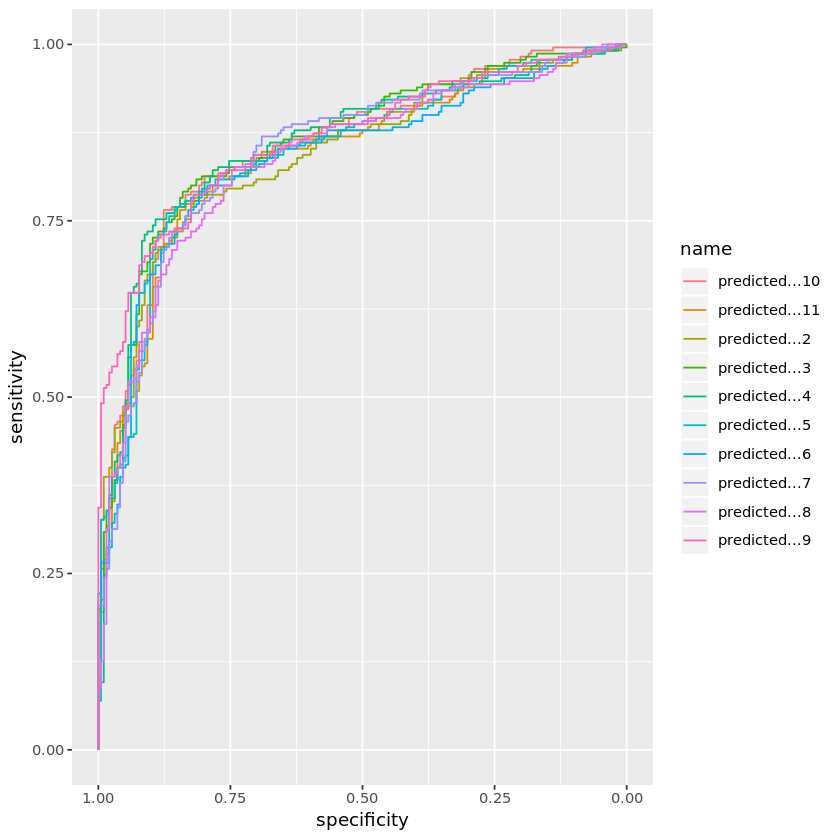

In [13]:
rocs <- roc(observed ~ predicted...2 + 
                    predicted...3 + 
                    predicted...4 + 
                    predicted...5 + 
                    predicted...6 +
                    predicted...7 +
                    predicted...8 + 
                    predicted...9 + 
                    predicted...10 + 
                    predicted...11, data = results)
ggroc(rocs)

In [14]:
roc1 <- roc(results$observed, results$predicted...2)
roc2 <- roc(results$observed, results$predicted...3)
roc3 <- roc(results$observed, results$predicted...4)
roc4 <- roc(results$observed, results$predicted...5)
roc5 <- roc(results$observed, results$predicted...6)
roc6 <- roc(results$observed, results$predicted...7)
roc7 <- roc(results$observed, results$predicted...8)
roc8 <- roc(results$observed, results$predicted...9)
roc9 <- roc(results$observed, results$predicted...10)
roc10 <- roc(results$observed, results$predicted...11)

In [15]:
(roc1$auc)

Area under the curve: 0.8464

In [16]:
paste("Mean AUC over 10 repetitions of 10-fold CV: ", mean(c(roc1$auc, roc2$auc, roc3$auc, roc4$auc, roc5$auc, roc6$auc, roc7$auc, roc8$auc, roc9$auc, roc10$auc)), sep = "")

[1] "Mean AUC over 10 repetitions of 10-fold CV: 0.850750784401614"

In [17]:
results_01 <- results %>% mutate(predicted...2_01 = ifelse(predicted...2 > 0.5, 1, 0), 
                                 predicted...3_01 = ifelse(predicted...3 > 0.5, 1, 0), 
                                 predicted...4_01 = ifelse(predicted...4 > 0.5, 1, 0),
                                 predicted...5_01 = ifelse(predicted...5 > 0.5, 1, 0),
                                 predicted...6_01 = ifelse(predicted...6 > 0.5, 1, 0),
                                 predicted...7_01 = ifelse(predicted...7 > 0.5, 1, 0),
                                 predicted...8_01 = ifelse(predicted...8 > 0.5, 1, 0),
                                 predicted...9_01 = ifelse(predicted...9 > 0.5, 1, 0),
                                 predicted...10_01 = ifelse(predicted...10 > 0.5, 1, 0),
                                 predicted...11_01 = ifelse(predicted...11 > 0.5, 1, 0))

In [18]:
error_rates <- c(mean(results_01$observed != results_01$predicted...2_01), 
                mean(results_01$observed != results_01$predicted...3_01),
               mean(results_01$observed != results_01$predicted...4_01),
               mean(results_01$observed != results_01$predicted...5_01),
               mean(results_01$observed != results_01$predicted...6_01),
               mean(results_01$observed != results_01$predicted...7_01),
               mean(results_01$observed != results_01$predicted...8_01),
               mean(results_01$observed != results_01$predicted...9_01), 
               mean(results_01$observed != results_01$predicted...10_01), 
               mean(results_01$observed != results_01$predicted...11_01))

error_rates

paste("Mean error rate over 10 repetitions of 10-fold CV: ", mean(error_rates), sep = "")

[1] 0.2051887 0.1910377 0.2004717 0.2028302 0.2099057 0.2169811 0.2193396
 [8] 0.2051887 0.1957547 0.2099057

[1] "Mean error rate over 10 repetitions of 10-fold CV: 0.205660377358491"

In [19]:
accuracies <- c(mean(results_01$observed == results_01$predicted...2_01),
               mean(results_01$observed == results_01$predicted...3_01), 
               mean(results_01$observed == results_01$predicted...4_01),
               mean(results_01$observed == results_01$predicted...5_01),
               mean(results_01$observed == results_01$predicted...6_01),
               mean(results_01$observed == results_01$predicted...7_01),
               mean(results_01$observed == results_01$predicted...8_01),
               mean(results_01$observed == results_01$predicted...9_01), 
               mean(results_01$observed == results_01$predicted...10_01), 
               mean(results_01$observed == results_01$predicted...11_01))

accuracies
paste("Mean accuracy over 10 repetitions of 10-fold CV: ", mean(accuracies), sep = "")

[1] 0.7948113 0.8089623 0.7995283 0.7971698 0.7900943 0.7830189 0.7806604
 [8] 0.7948113 0.8042453 0.7900943

[1] "Mean accuracy over 10 repetitions of 10-fold CV: 0.794339622641509"